In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as sch

from plotnine import *

In [26]:
cars = pd.read_csv("cars.csv")

# see current columns
print("Columns: ")
print(cars.columns)

# see null values
print(cars.isna().sum())

# drop null values
cars.dropna(inplace = True)
cars.reset_index()

# check drop
print(cars.isna().sum())

print("Unique fuels: ")
unique_fuels = cars["fuel"].unique()
print(unique_fuels)

unique_gears = cars["gear"].unique()
print("Unique gears: ")
print(unique_gears)

print("Unique offerTypes: ")
unique_offer_types = cars["offerType"].unique()
print(unique_offer_types)

# check size
print(f"Rows: {cars.shape[0]}, Cols: {cars.shape[1]}")

# Others and -/- (Fuel) tell us nothing, see if they dont make up a large part of the dataset
num_others_fuel = len(cars.loc[cars["fuel"] == "Others"])
num_misc_fuel = len(cars.loc[cars["fuel"] == "-/- (Fuel)"])
print(f"Number of cars with Others fuel type: {num_others_fuel}")
print(f"Number of cars with -/- (Fuel) fuel type: {num_misc_fuel}")

# they make up only a combined 69 rows out of 46,071, okay to drop
cars = cars[cars["fuel"] != "Others"]
cars = cars[cars["fuel"] != "-/- (Fuel)"]

# checking for proper cleaning
print("--------------------------")
print("After clean")

print("Unique fuels: ")
unique_fuels = cars["fuel"].unique()
print(unique_fuels)

print("Unique gears: ")
unique_gears = cars["gear"].unique()
print(unique_gears)

print("Unique offerTypes: ")
unique_offer_types = cars["offerType"].unique()
print(unique_offer_types)

print(f"Rows: {cars.shape[0]}, Cols: {cars.shape[1]}")

# dropping model column, theyre all unique and tell us nothing
cars.drop("model", axis = 1, inplace = True)

print("Columns after model drop: ")
print(cars.columns)

cars.head()

# renaming Electric/(Gasoline OR Diesel) to more interpretable names
cars["fuel"] = cars["fuel"].replace({"Electric/Diesel" : "DieselHybrid", "Electric/Gasoline" : "GasolineHybrid"})

print("Unique fuels: ")
unique_fuels = cars["fuel"].unique()
print(unique_fuels)

print(f"Rows: {cars.shape[0]}, Cols: {cars.shape[1]}")

print("Median price:", cars["price"].median())

Columns: 
Index(['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'price', 'hp',
       'year'],
      dtype='object')
mileage        0
make           0
model        143
fuel           0
gear         182
offerType      0
price          0
hp            29
year           0
dtype: int64
mileage      0
make         0
model        0
fuel         0
gear         0
offerType    0
price        0
hp           0
year         0
dtype: int64
Unique fuels: 
['Diesel' 'Gasoline' 'Electric/Gasoline' '-/- (Fuel)' 'Electric'
 'Electric/Diesel' 'CNG' 'LPG' 'Others' 'Hydrogen' 'Ethanol']
Unique gears: 
['Manual' 'Automatic' 'Semi-automatic']
Unique offerTypes: 
['Used' 'Demonstration' "Employee's car" 'Pre-registered' 'New']
Rows: 46071, Cols: 9
Number of cars with Others fuel type: 47
Number of cars with -/- (Fuel) fuel type: 22
--------------------------
After clean
Unique fuels: 
['Diesel' 'Gasoline' 'Electric/Gasoline' 'Electric' 'Electric/Diesel'
 'CNG' 'LPG' 'Hydrogen' 'Ethanol']
Unique gear

# Q1, Linear Regression

Question: Can we accurately predict the sale price of a vehicle given all other specifications
(excluding model)? How accurately can we predict a vehicle's price using only the continuous
variables compared to using all predictors?

Variables involved:  mileage (continuous), make (categorical), fuel (categorical), gear
(categorical), offerType(categorical), hp (continuous), year (continuous/interval), price
(continuous)

Cleaning:  Missing values will be dropped. Make, fuel, offerType, gear will be dummied using
get_dummies(). Mileage, price, hp, and year will be Z scored.

Modeling/Computation: An 80/20 train test split will be used. Two LinearRegression models
will be fit on the data, one using all predictors, and one using only continuous. They will then be
evaluated based on MAE, MSE, and R^2.

Graphs: A bar chart will be created displaying the train and test metrics for each model. In
addition to this, residual plots will be created for each model to verify LinearRegeression
assumptions.

Brief discussion of why analysis is effective at answering question: This analysis is
effective in answering the question as it compares the two different modeling instances (all
variables vs only continuous) and each models performance on the data. The ggplots will serve
to verify if the data has a true linear relationship or should be reanalyzed possibly recomputed
using polynomial features.

### Building model with all predictors


In [3]:
# with all predictors
cont_cols = ["mileage", "hp", "year"]
cat_cols = ["make", "fuel", "gear", "offerType"]

d_cars = pd.get_dummies(cars, columns = cat_cols)

X = d_cars.drop("price", axis = 1)
y = d_cars["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_all_train = mean_squared_error(y_train,y_pred_train)
mae_all_train = mean_absolute_error(y_train,y_pred_train)
r2_all_train = r2_score(y_train,y_pred_train)
mse_all_test = mean_squared_error(y_test,y_pred_test)
mae_all_test = mean_absolute_error(y_test,y_pred_test)
r2_all_test = r2_score(y_test,y_pred_test)

print("Train MSE : ", mse_all_train)
print("Train MAE : ", mae_all_train)
print("Train R2  : ", r2_all_train)
print("---------------------")
print("Test MSE  : ", mse_all_test)
print("Test MAE  : ", mae_all_test)
print("Test R2   : ", r2_all_test)

Train MSE :  54312907.89661958
Train MAE :  3631.4955118579005
Train R2  :  0.8298624072733505
---------------------
Test MSE  :  197689724.62598917
Test MAE  :  3996.76886004855
Test R2   :  0.660889162380432


### Checking Assumptions

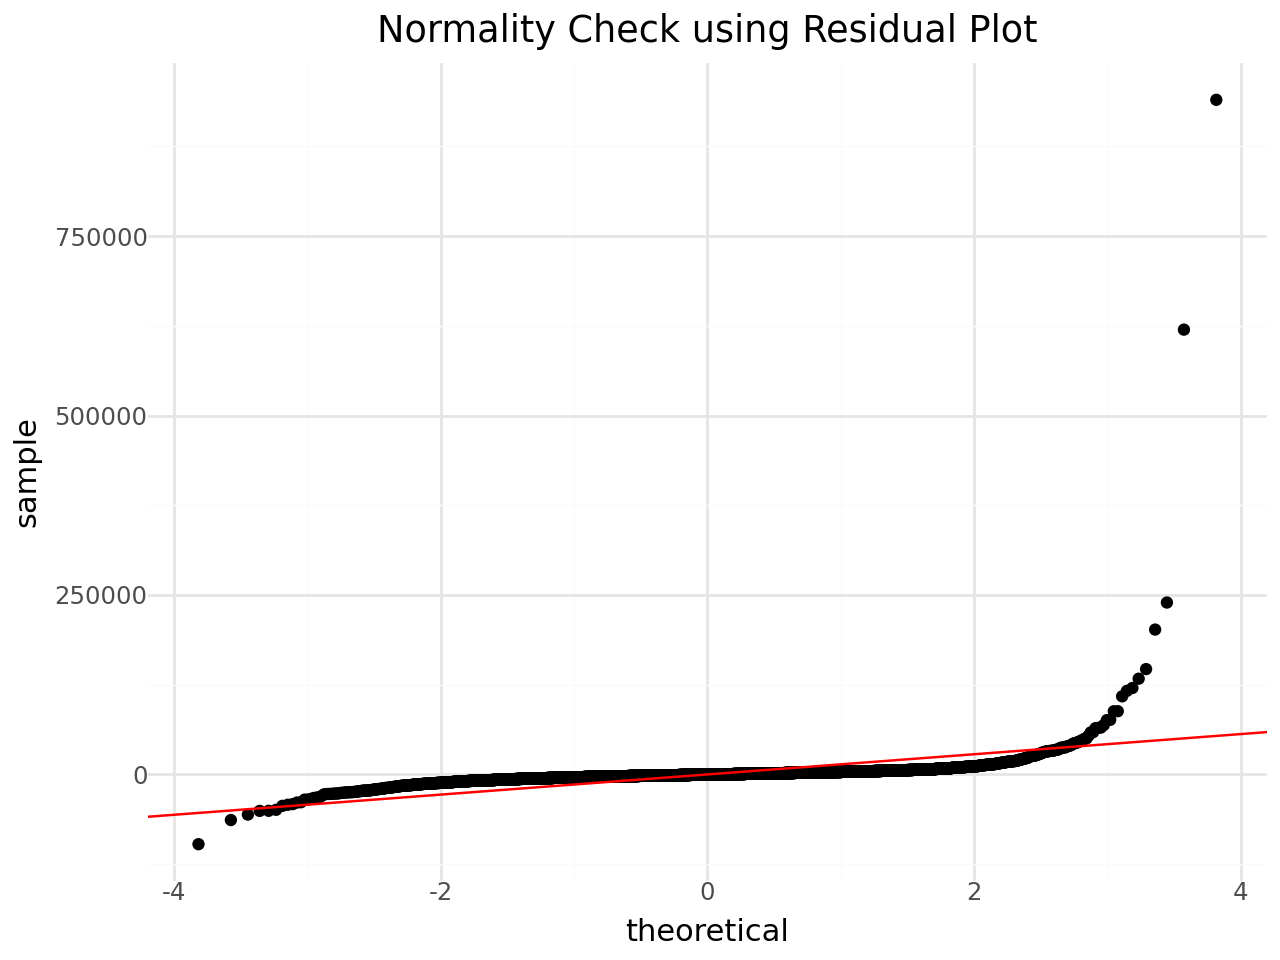

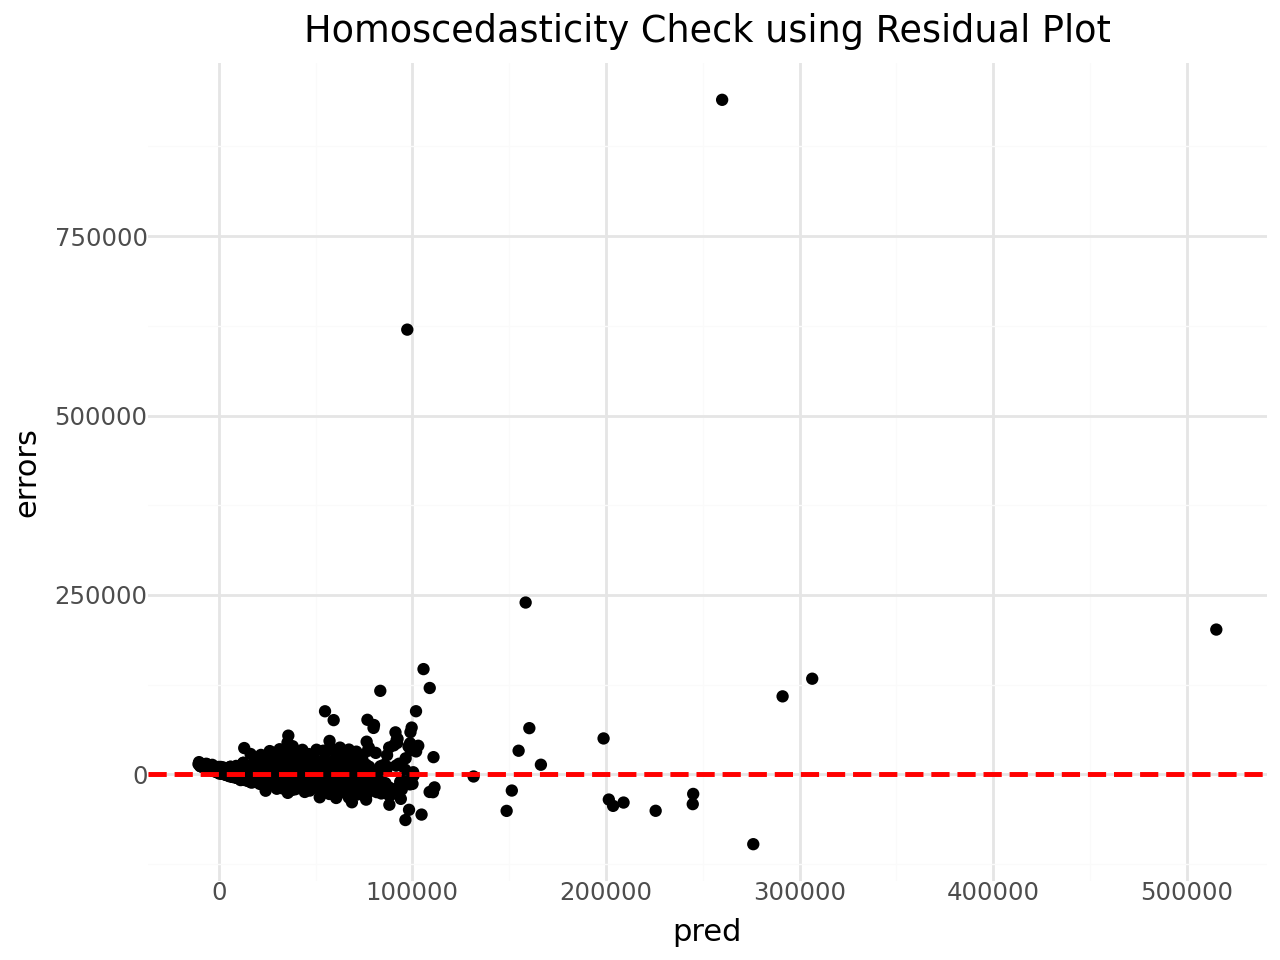

In [5]:
assump = pd.DataFrame({"errors": y_test - y_pred_test,
                      "pred": y_pred_test})

display(ggplot(assump, aes(sample = "errors")) +
stat_qq() + theme_minimal() + geom_abline(intercept = 0,
                                          slope = np.std(assump["errors"]),
                                          color = "red") + labs(title = "Normality Check using Residual Plot"))

display(ggplot(assump, aes(x = "pred", y = "errors")) +
 geom_point() +
 theme_minimal() +
 geom_hline(yintercept = 0, linetype = "dashed", size = 1, color = "red") + labs(title = "Homoscedasticity Check using Residual Plot"))

### Building Model with only Continuous Predictors

In [6]:
# with only continuous predictors

X = cars[cont_cols]
y = cars["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mse_cont_train = mean_squared_error(y_train,y_pred_train)
mae_cont_train = mean_absolute_error(y_train,y_pred_train)
r2_cont_train = r2_score(y_train,y_pred_train)
mse_cont_test = mean_squared_error(y_test,y_pred_test)
mae_cont_test = mean_absolute_error(y_test,y_pred_test)
r2_cont_test = r2_score(y_test,y_pred_test)

print("Train MSE : ", mse_cont_train)
print("Train MAE : ", mae_cont_train)
print("Train R2  : ", r2_cont_train)
print("-------------------")
print("Test MSE  : ", mse_cont_test)
print("Test MAE  : ", mae_cont_test)
print("Test R2   : ", r2_cont_test)

Train MSE :  86479167.12041436
Train MAE :  4441.398752542113
Train R2  :  0.7291001737031158
-------------------
Test MSE  :  293549491.9075277
Test MAE  :  4808.462485025802
Test R2   :  0.4964542832365626


### Checking Assumptions Again

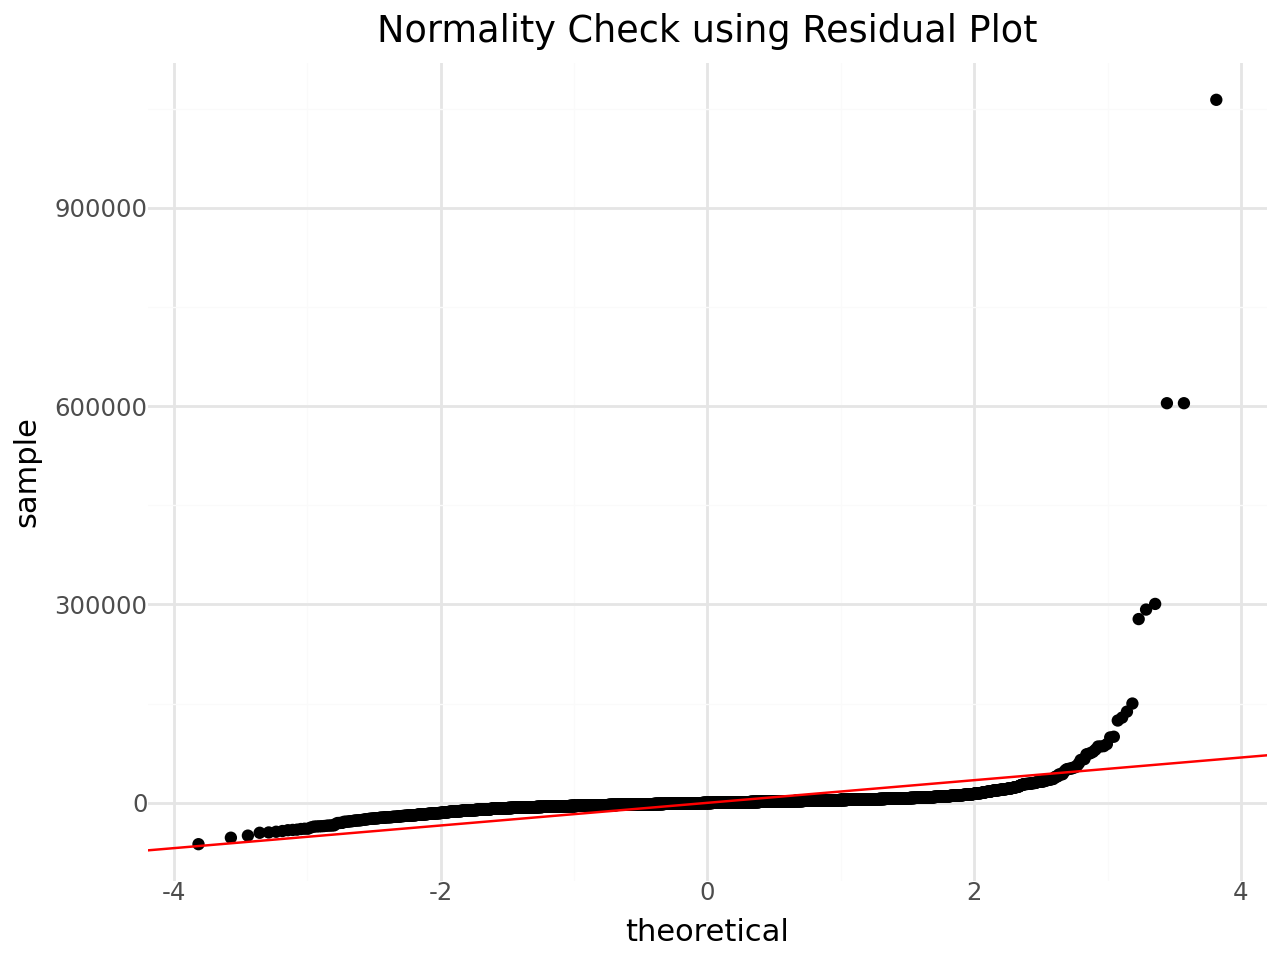

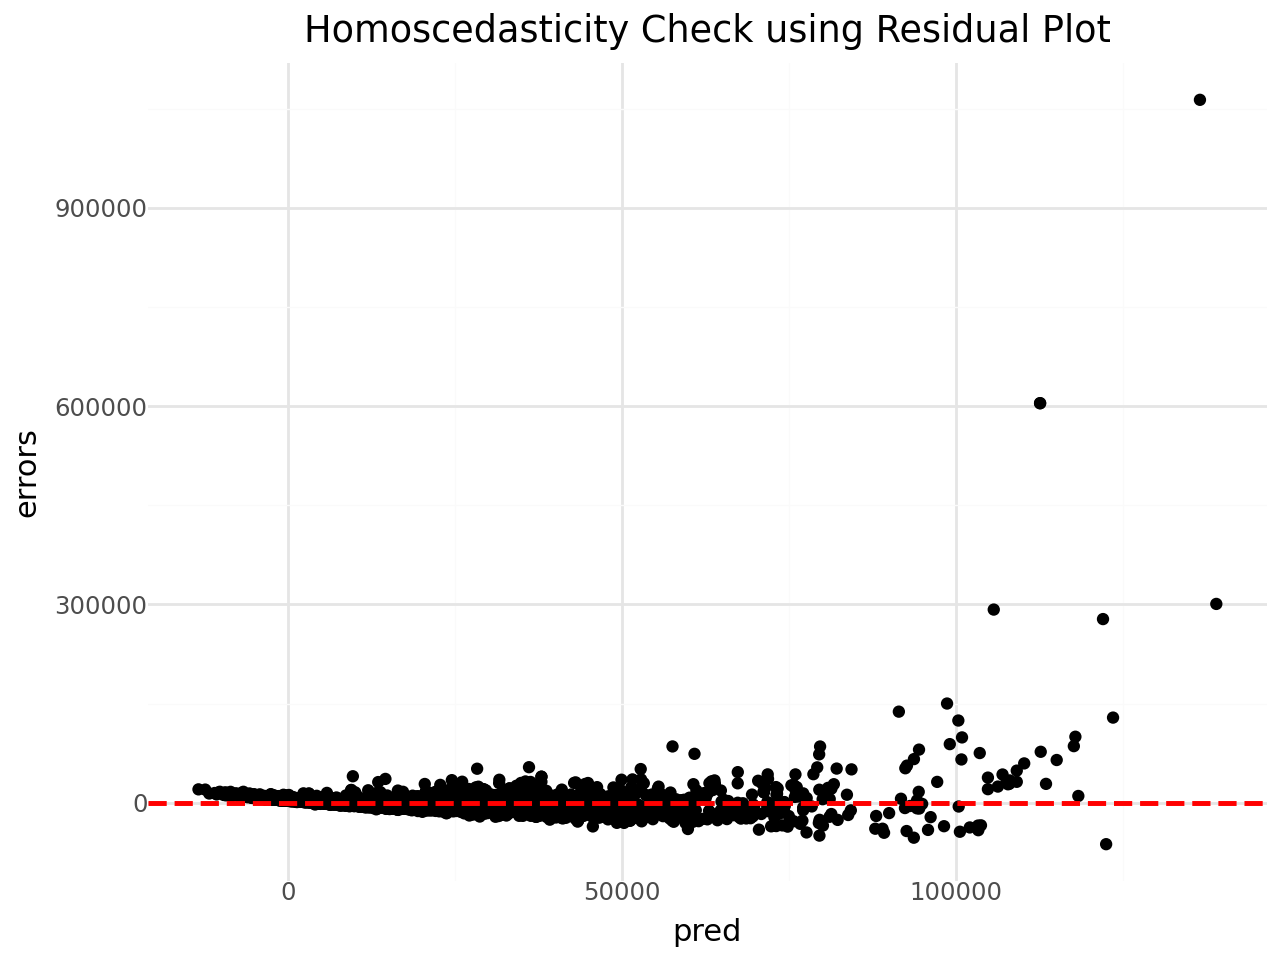

In [7]:
assump = pd.DataFrame({"errors": y_test - y_pred_test,
                      "pred": y_pred_test})

display(ggplot(assump, aes(sample = "errors")) +
stat_qq() + theme_minimal() + geom_abline(intercept = 0,
                                          slope = np.std(assump["errors"]),
                                          color = "red") + labs(title = "Normality Check using Residual Plot"))

display(ggplot(assump, aes(x = "pred", y = "errors")) +
 geom_point() +
 theme_minimal() +
 geom_hline(yintercept = 0, linetype = "dashed", size = 1, color = "red") + labs(title = "Homoscedasticity Check using Residual Plot"))

### Comparing Train & Test Metrics for All Metrics

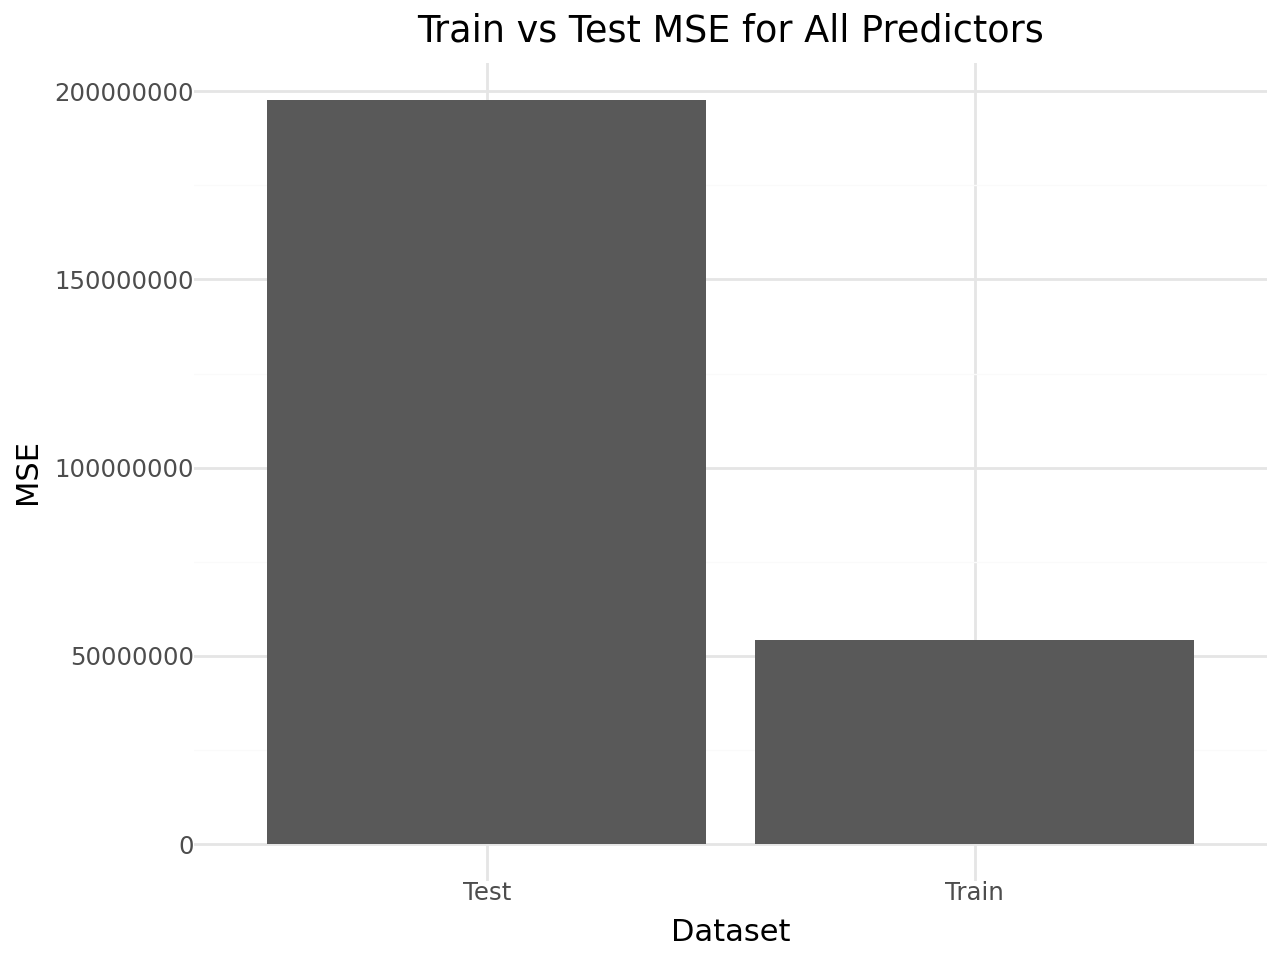

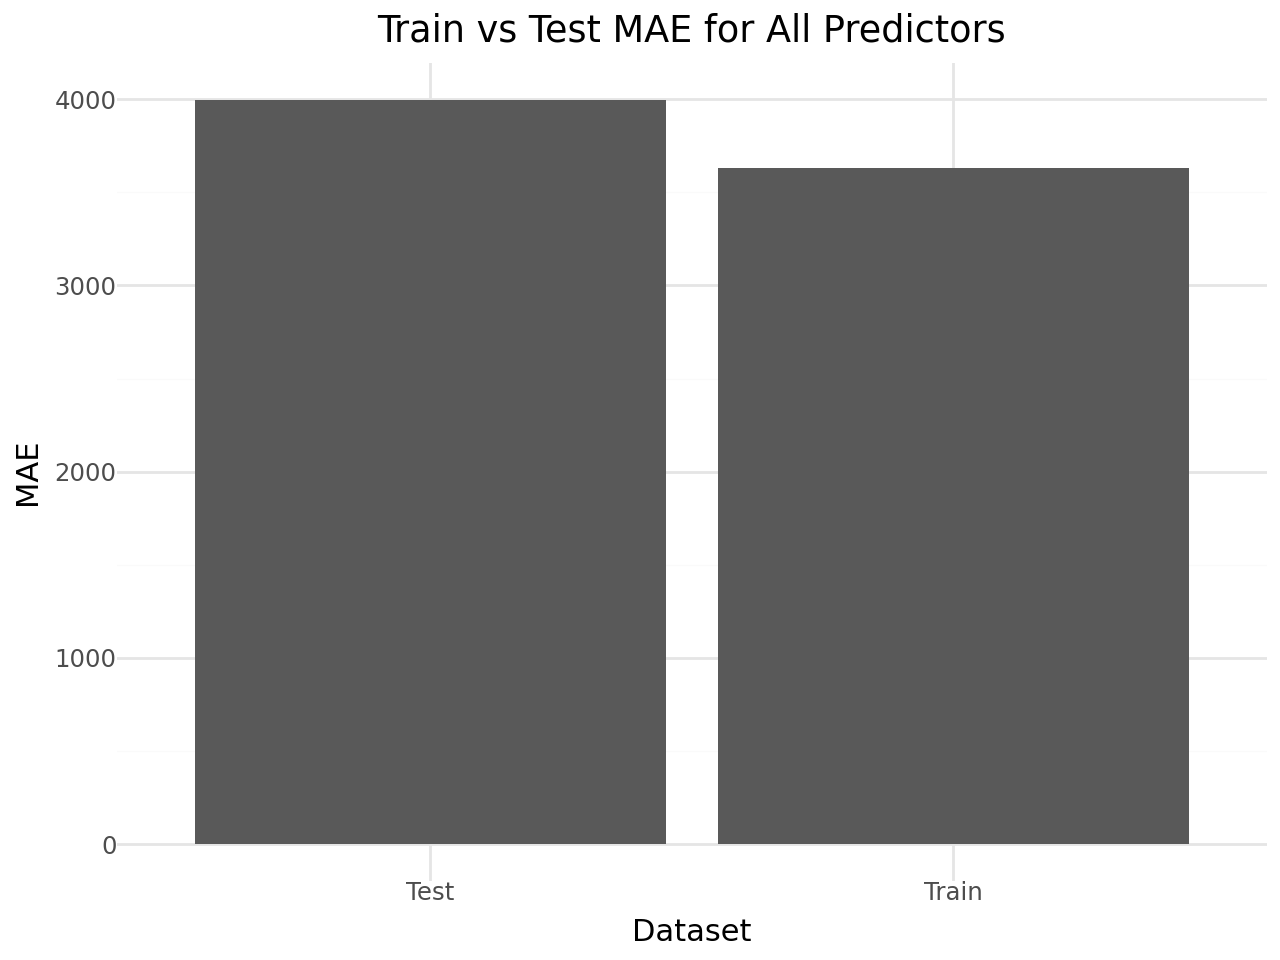

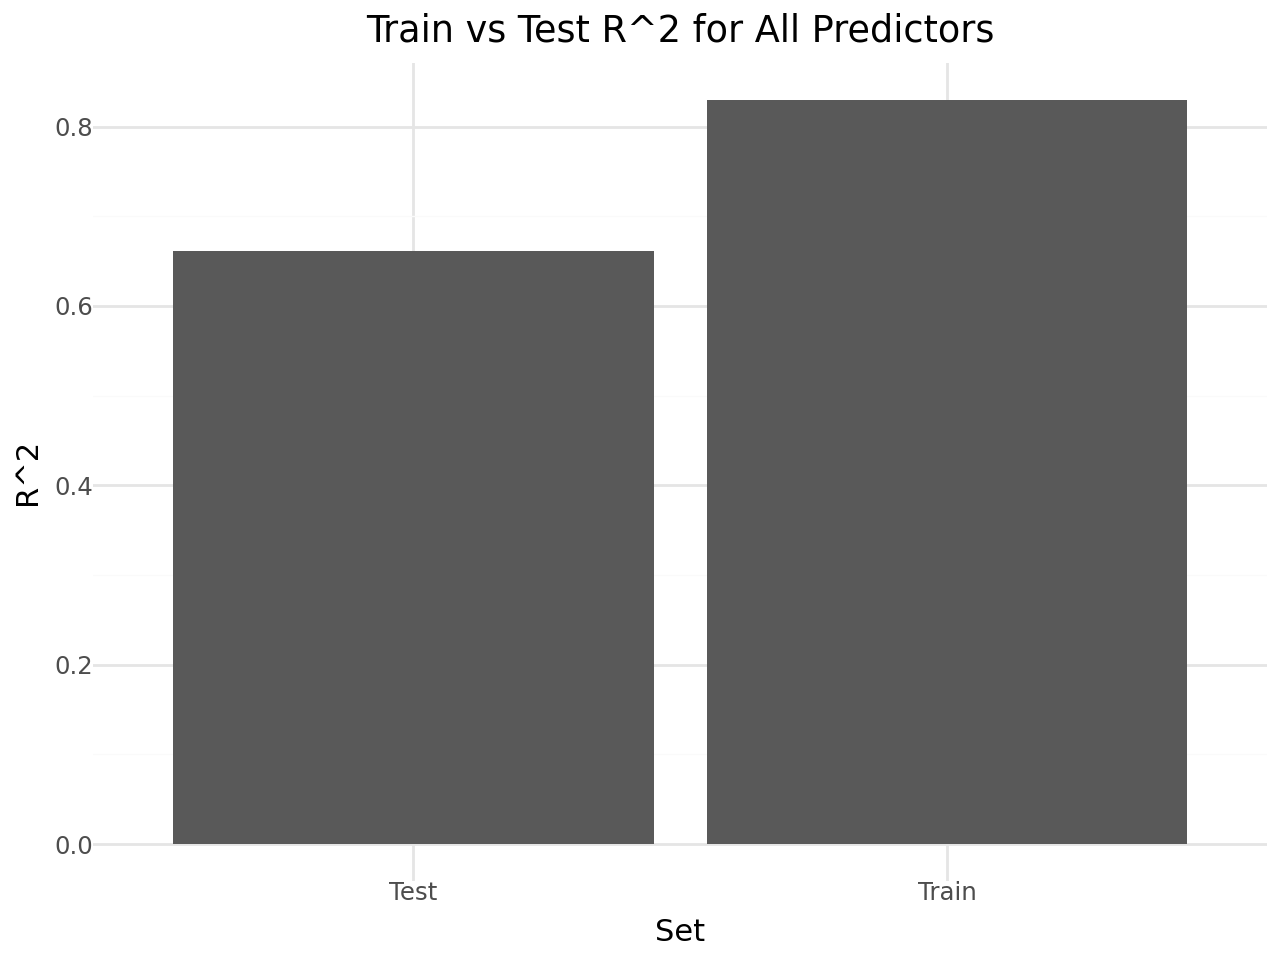

In [8]:
mae_all_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [mae_all_train, mae_all_test]
})

mse_all_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [mse_all_train, mse_all_test]
})

r2_all_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [r2_all_train, r2_all_test]
})

# was having error with using geom_bar()
# REFERENCES FOR geom_col(): https://plotnine.org/reference/geom_col.html#plotnine.geom_col, https://stackoverflow.com/questions/59008974/why-is-stat-identity-necessary-in-geom-bar-in-ggplot
display(
    ggplot(mse_all_df, aes(x = "Type", y = "Values")) +
    geom_col() +
    labs(title="Train vs Test MSE for All Predictors", x = "Dataset", y = "MSE") +
    theme_minimal()
)

display(
    ggplot(mae_all_df, aes(x = "Type", y = "Values")) +
    geom_col() +
    labs(title="Train vs Test MAE for All Predictors", x = "Dataset", y = "MAE") +
    theme_minimal()
)

display(
    ggplot(r2_all_df, aes(x="Type", y="Values")) +
    geom_col() +
    labs(title="Train vs Test R^2 for All Predictors", x = "Set", y = "R^2") +
    theme_minimal()
)

### Comparing Train & Test Metrics for Continuous Predictors

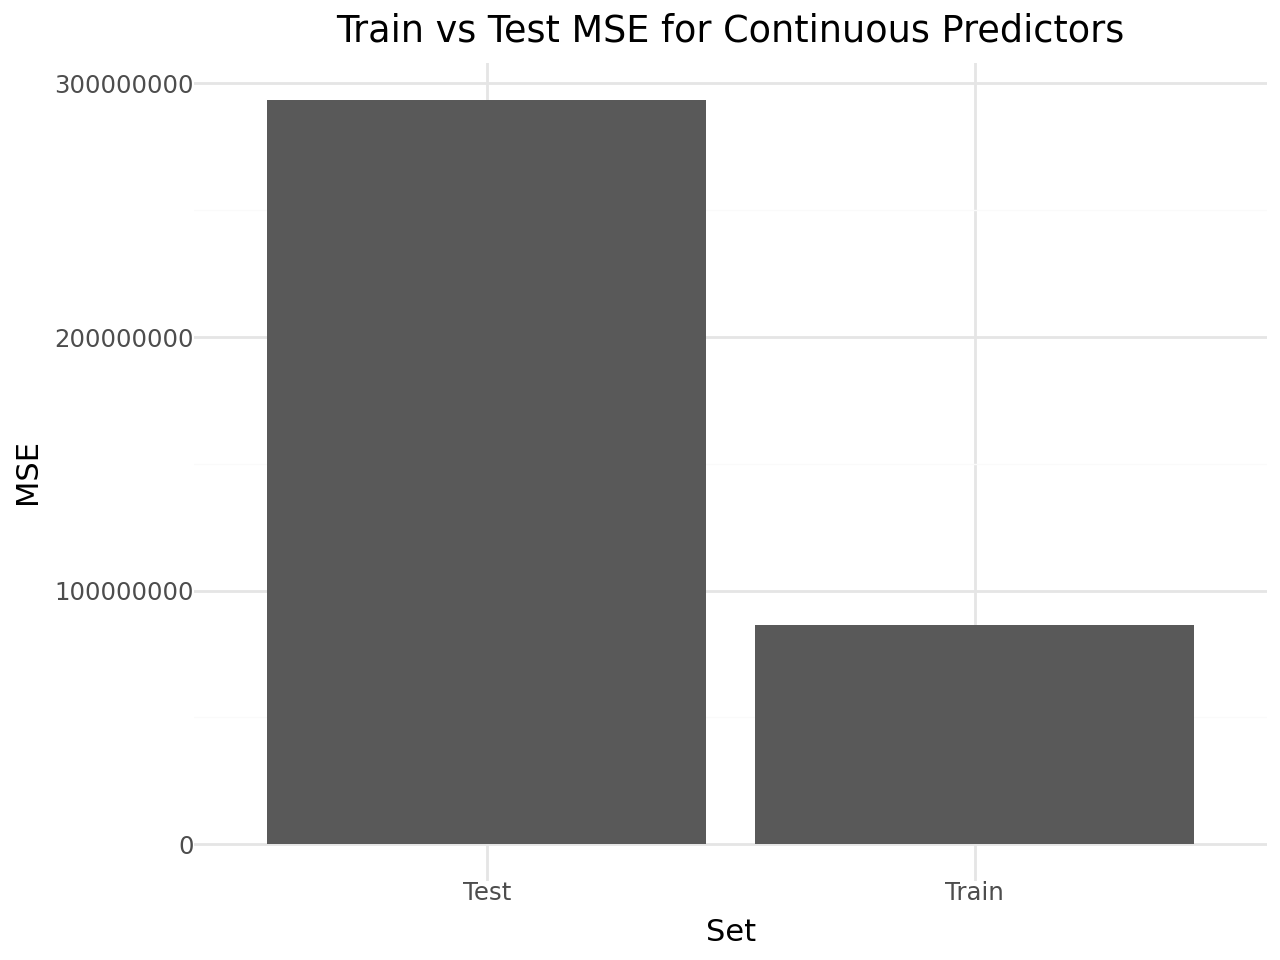

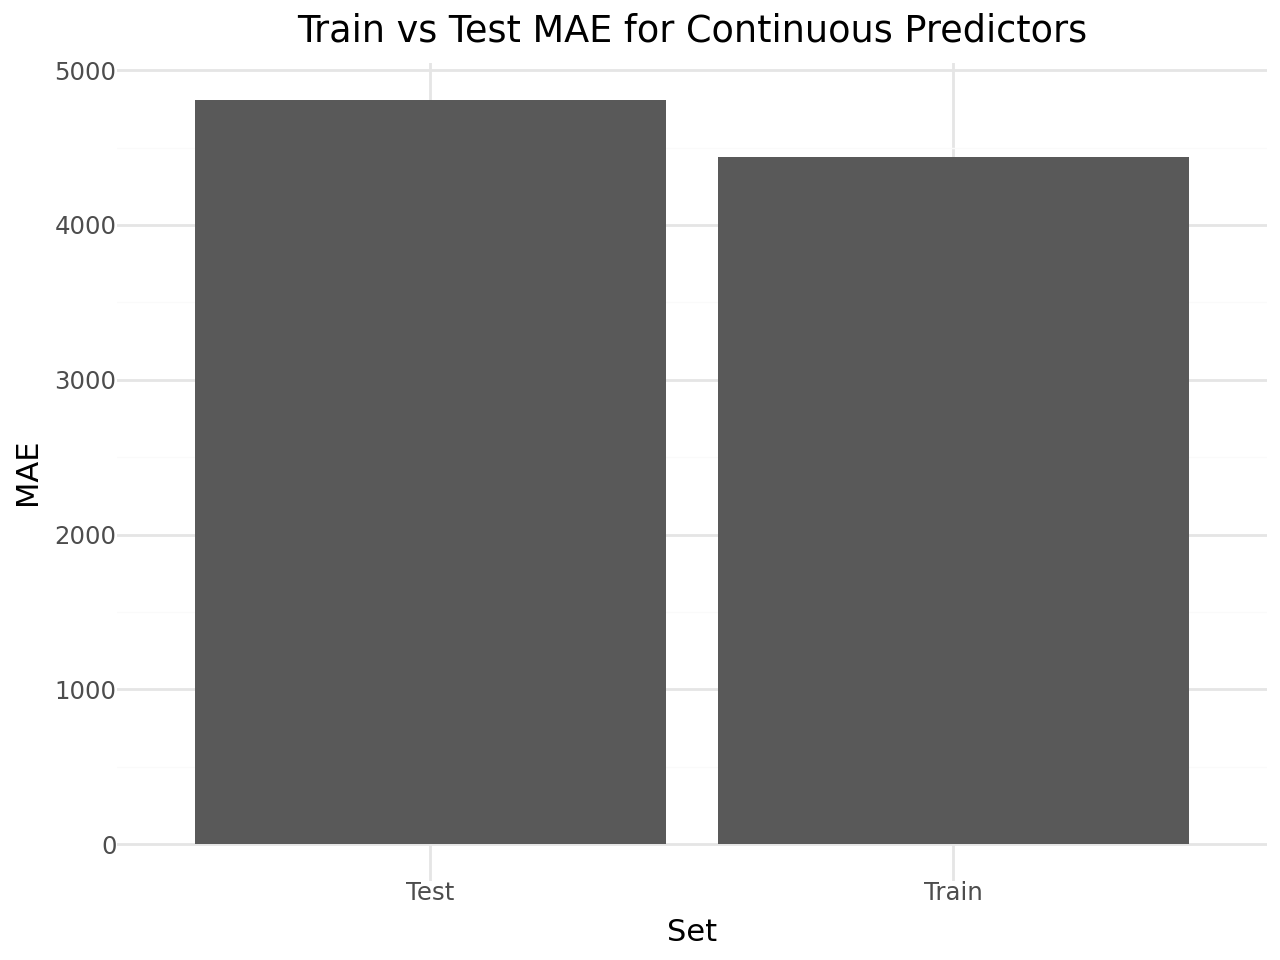

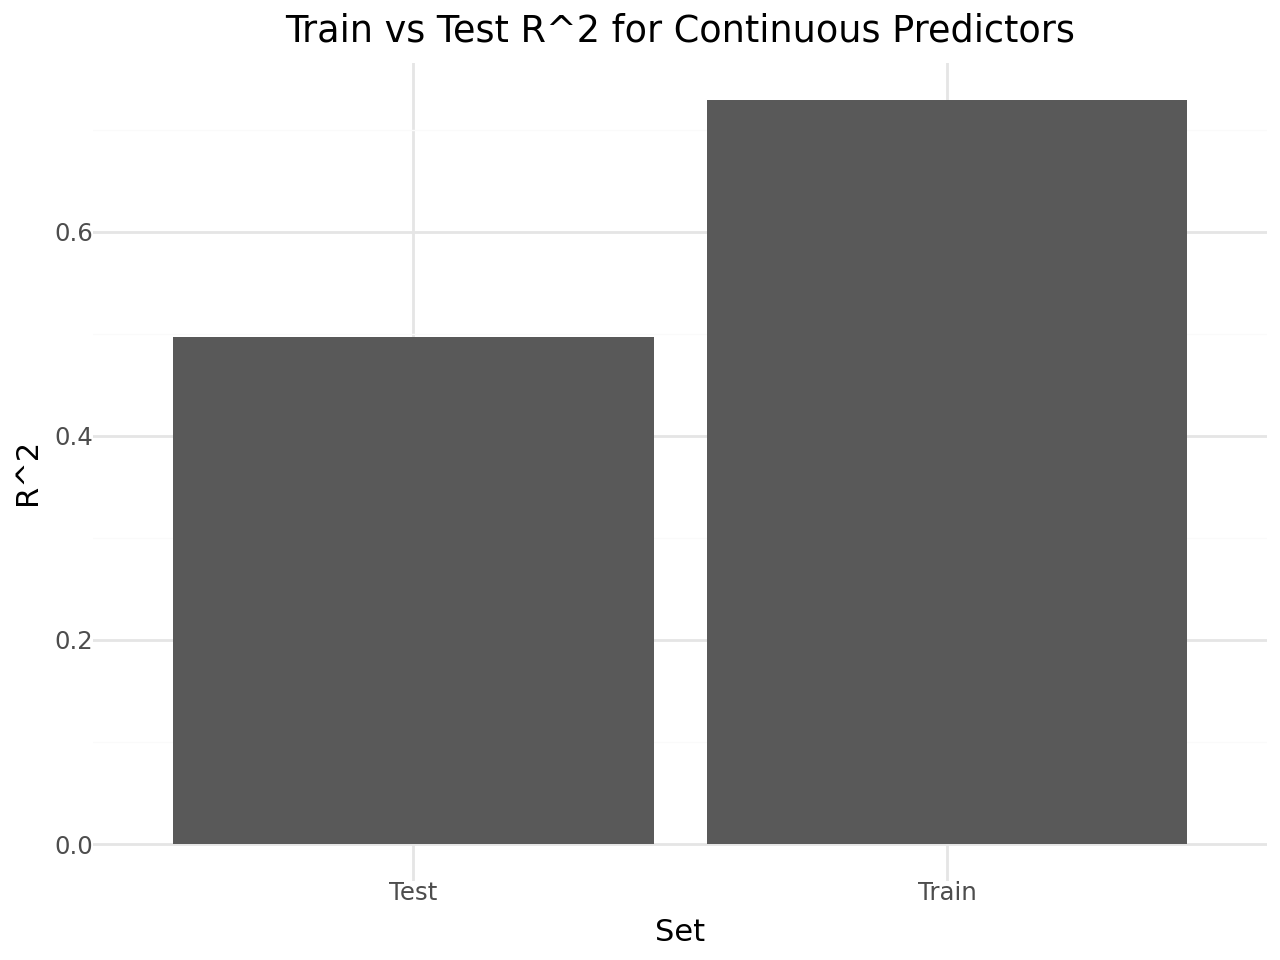

In [9]:
mae_cont_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [mae_cont_train, mae_cont_test]
})

mse_cont_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [mse_cont_train, mse_cont_test]
})

r2_cont_df = pd.DataFrame({
    "Type" : ["Train", "Test"],
    "Values" : [r2_cont_train, r2_cont_test]
})

display(
    ggplot(mse_cont_df, aes(x = "Type", y = "Values")) +
    geom_col() +
    labs(title="Train vs Test MSE for Continuous Predictors", x = "Set", y = "MSE") +
    theme_minimal()
)

display(
    ggplot(mae_cont_df, aes(x = "Type", y = "Values")) +
    geom_col() +
    labs(title="Train vs Test MAE for Continuous Predictors", x = "Set", y = "MAE") +
    theme_minimal()
)

display(
    ggplot(r2_cont_df, aes(x="Type", y="Values")) +
    geom_col() +
    labs(title="Train vs Test R^2 for Continuous Predictors", x = "Set", y = "R^2") +
    theme_minimal()
)

### Comparing performance between All & Continuous Predictors

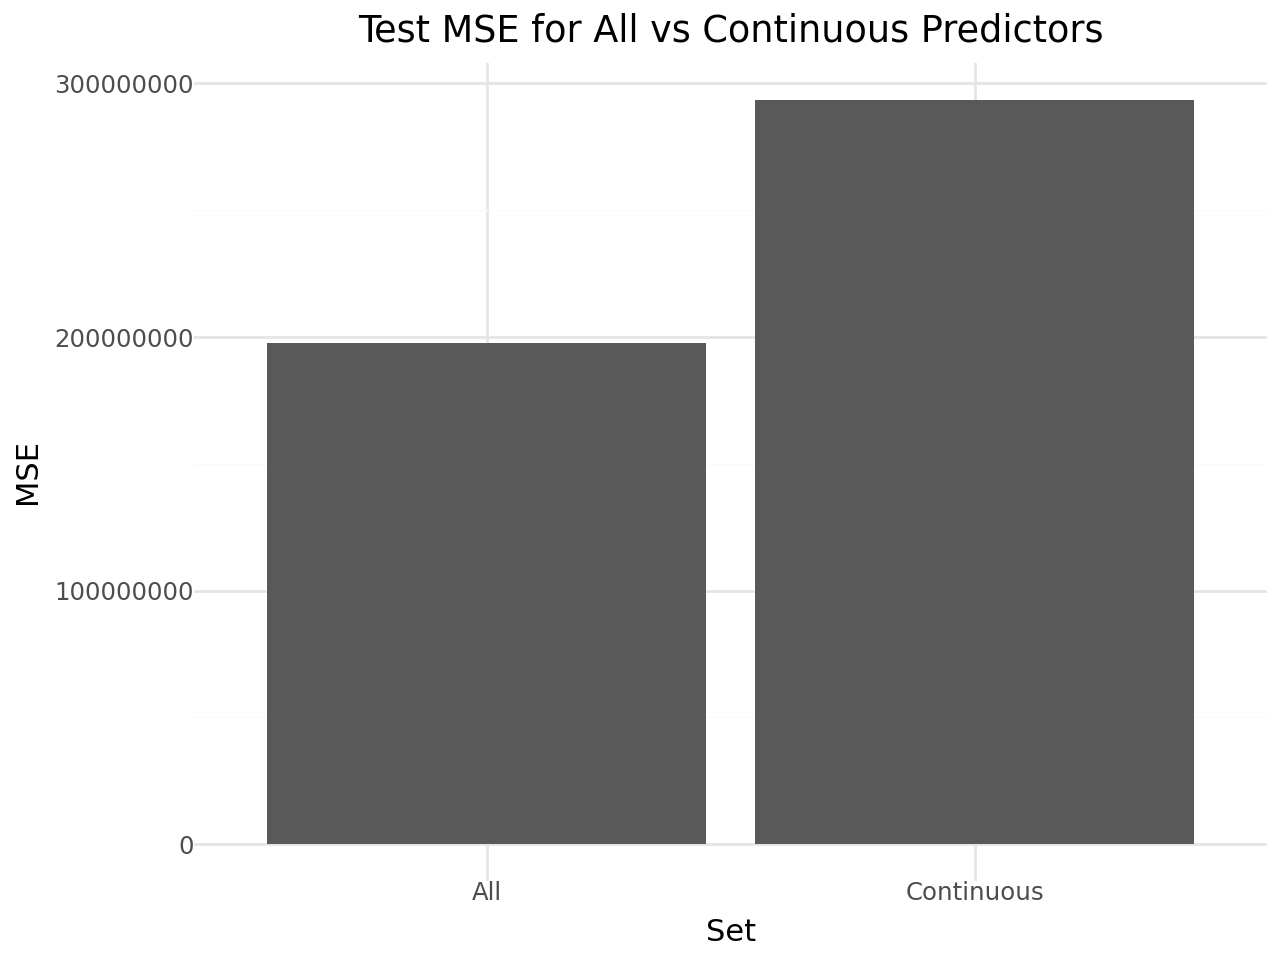

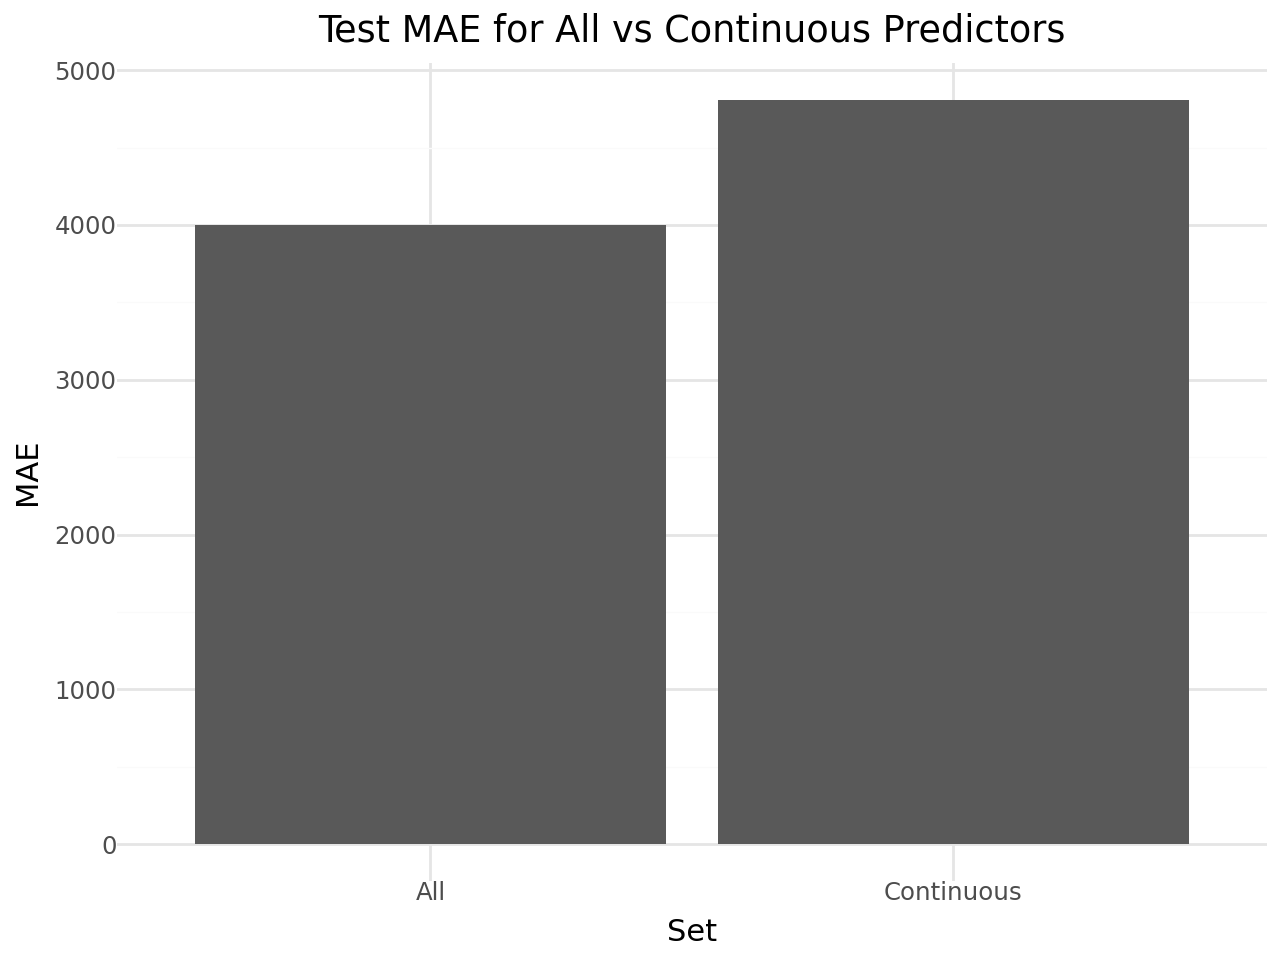

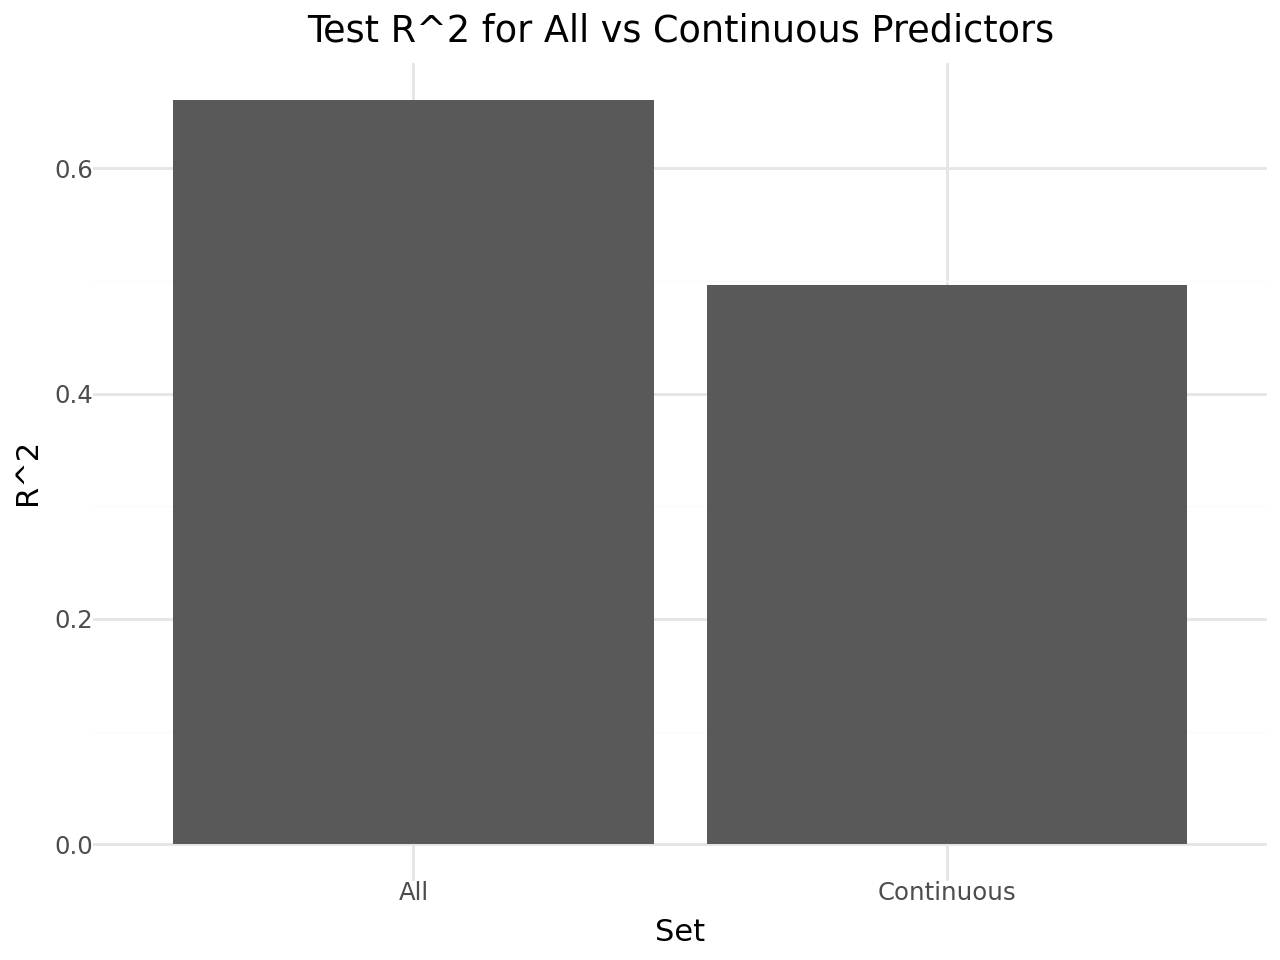

In [10]:
mae_all_vs_cont = pd.DataFrame({
    "Predictors" : ["All", "Continuous"],
    "Values" : [mae_all_test, mae_cont_test]
})

mse_all_vs_cont = pd.DataFrame({
    "Predictors" : ["All", "Continuous"],
    "Values" : [mse_all_test, mse_cont_test]
})

r2_all_vs_cont = pd.DataFrame({
    "Predictors" : ["All", "Continuous"],
    "Values" : [r2_all_test, r2_cont_test]
})

display(
    ggplot(mse_all_vs_cont, aes(x = "Predictors", y = "Values")) +
    geom_col() +
    labs(title="Test MSE for All vs Continuous Predictors", x = "Set", y = "MSE") +
    theme_minimal()
)

display(
    ggplot(mae_all_vs_cont, aes(x = "Predictors", y = "Values")) +
    geom_col() +
    labs(title="Test MAE for All vs Continuous Predictors", x = "Set", y = "MAE") +
    theme_minimal()
)

display(
    ggplot(r2_all_vs_cont, aes(x="Predictors", y="Values")) +
    geom_col() +
    labs(title="Test R^2 for All vs Continuous Predictors", x = "Set", y = "R^2") +
    theme_minimal()
)

# Q2, PCA

Q2
Question: How well does a PCA model, designed to retain 90% of the variance in the data,
perform when compared to a non PCA linear regression model when predicting the price of a
vehicle based only on continuous features? (Measured in MSE, MAE, R^2)

Variables involved:  mileage (continuous), hp (continuous), year (continuous/interval), price
(continuous)

Cleaning:  Missing values will be dropped. All features/variables used  will be Z scored.
Modeling/Computation: A PCA model will be fit on the data to capture 90% of the variance. A
LinearRegression model will be trained on the PCA transformed data and evaluated based on
MAE, MSE, and R^2.

Graphs: A cumulative variance plot will be created to evaluate the efficiency of the various PCs.
After that, a bar chart will be created comparing the PCA LinearRegression model based on the
performance metrics to the Linear Regression model using raw continuous data.

Brief discussion of why analysis is effective at answering question: This analysis is
effective in answering the questions as it provides the required information needed to evaluate
the PCA models performance to the model only using raw data.

### Fitting PCA

In [11]:
X = cars[cont_cols]
y = cars["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()

pca.fit(X_train)

PCA()

### Checking Scree and Cumulaative Variance Plots

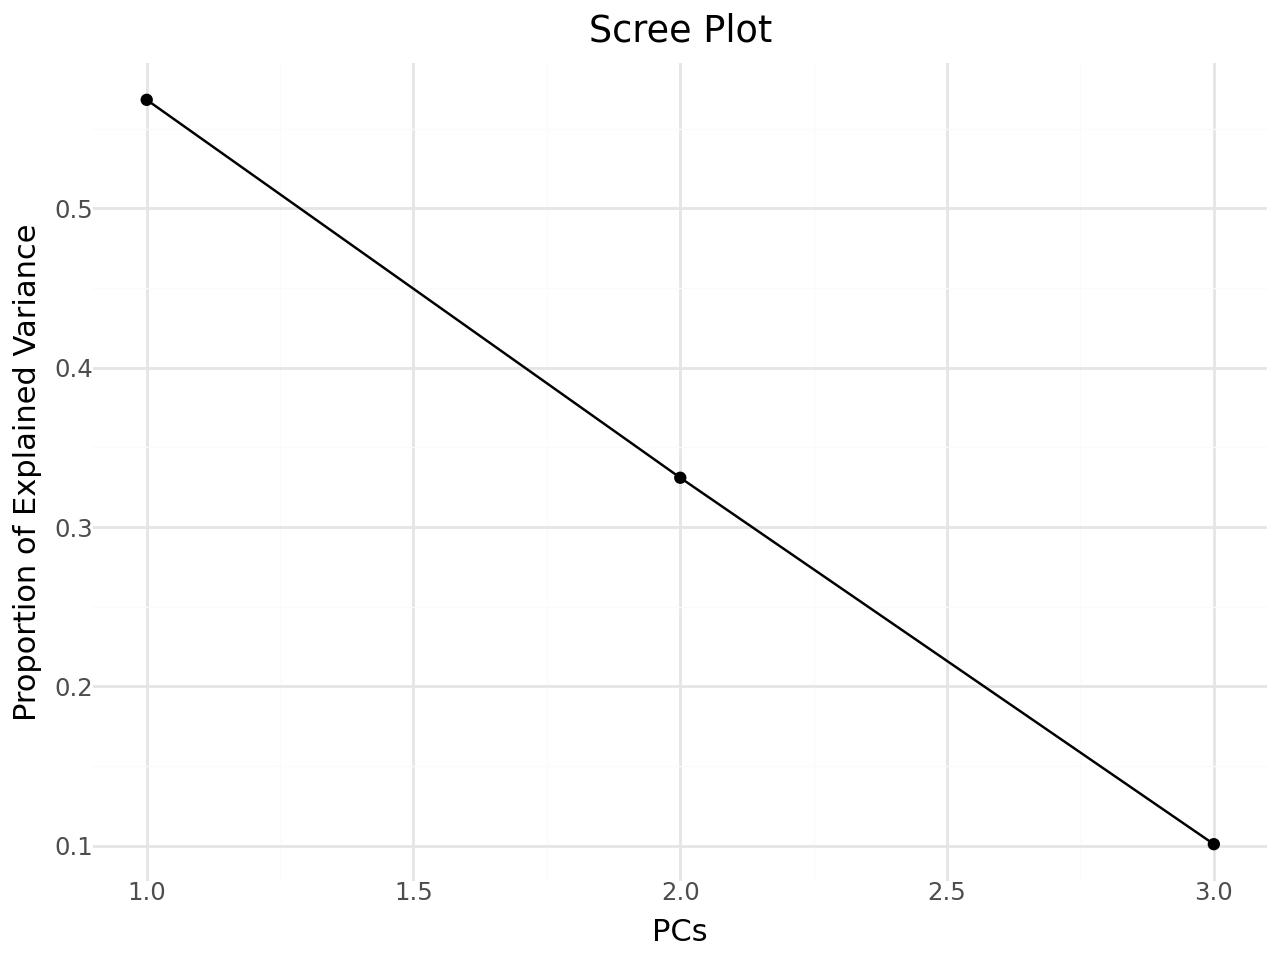

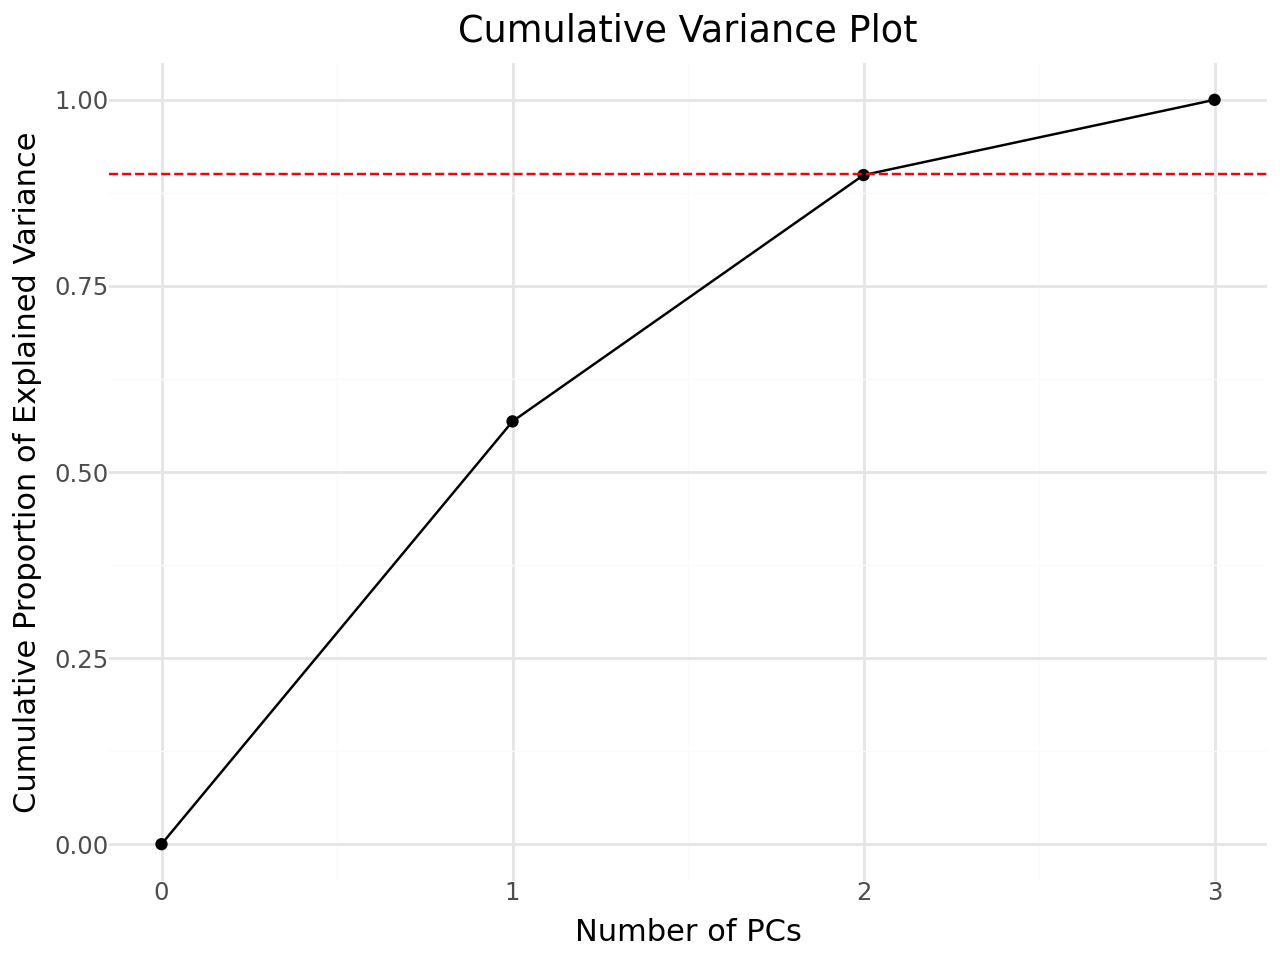

In [12]:
n_components = len(pca.explained_variance_ratio_) # had to figure out how many components PCA made ahead of time as was getting error when trying to use arbitrary range

pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_,
                      "pc": range(1, n_components + 1),
                      "cum_var":
                      pca.explained_variance_ratio_.cumsum()})

display(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})]) # normalize to 0,0

(ggplot(pcaDF0, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.9, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance", title = "Cumulative Variance Plot"))

### Fitting a Linear Regression on PCA Predictors

In [13]:
pca = PCA(n_components = 0.9)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LinearRegression()

lr.fit(X_train_pca, y_train)

LinearRegression()

### Getting Metrics

In [14]:
y_pred_train = lr.predict(X_train_pca)
y_pred_test = lr.predict(X_test_pca)

mse_pca_train = mean_squared_error(y_train,y_pred_train)
mae_pca_train = mean_absolute_error(y_train,y_pred_train)
r2_pca_train = r2_score(y_train,y_pred_train)
mse_pca_test = mean_squared_error(y_test,y_pred_test)
mae_pca_test = mean_absolute_error(y_test,y_pred_test)
r2_pca_test = r2_score(y_test,y_pred_test)

print("Train MSE: ", mse_pca_train)
print("Train MAE: ", mae_pca_train)
print("Train R2: ", r2_pca_train)
print("-------------------")
print("Test MSE:", mse_pca_test)
print("Test MAE:", mae_pca_test)
print("Test R2:", r2_pca_test)

Train MSE:  86479167.12041436
Train MAE:  4441.398752542112
Train R2:  0.7291001737031158
-------------------
Test MSE: 293549491.9075277
Test MAE: 4808.4624850258015
Test R2: 0.4964542832365626


### Comparing PCA vs Raw Continuous Features

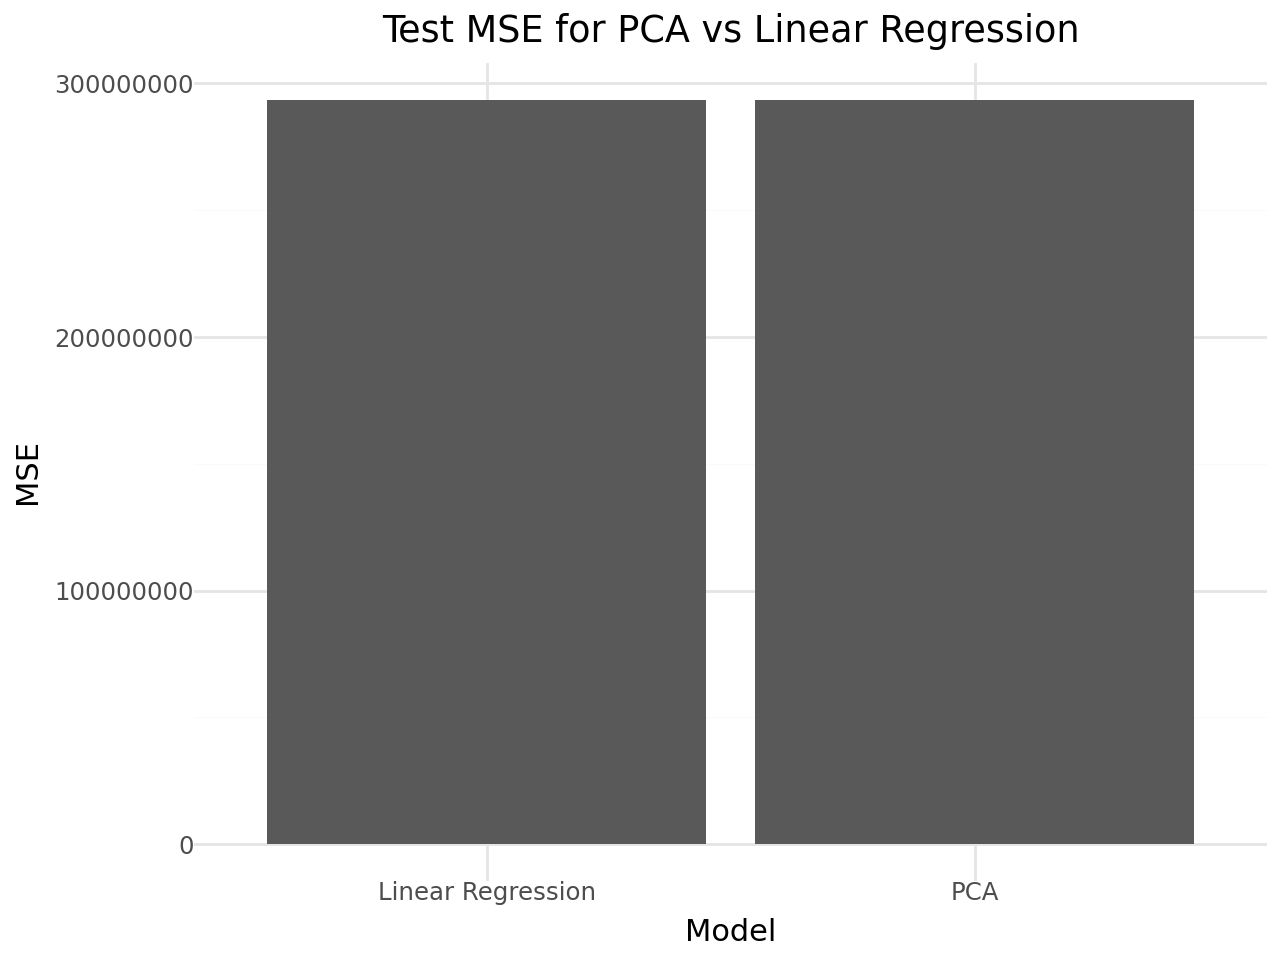

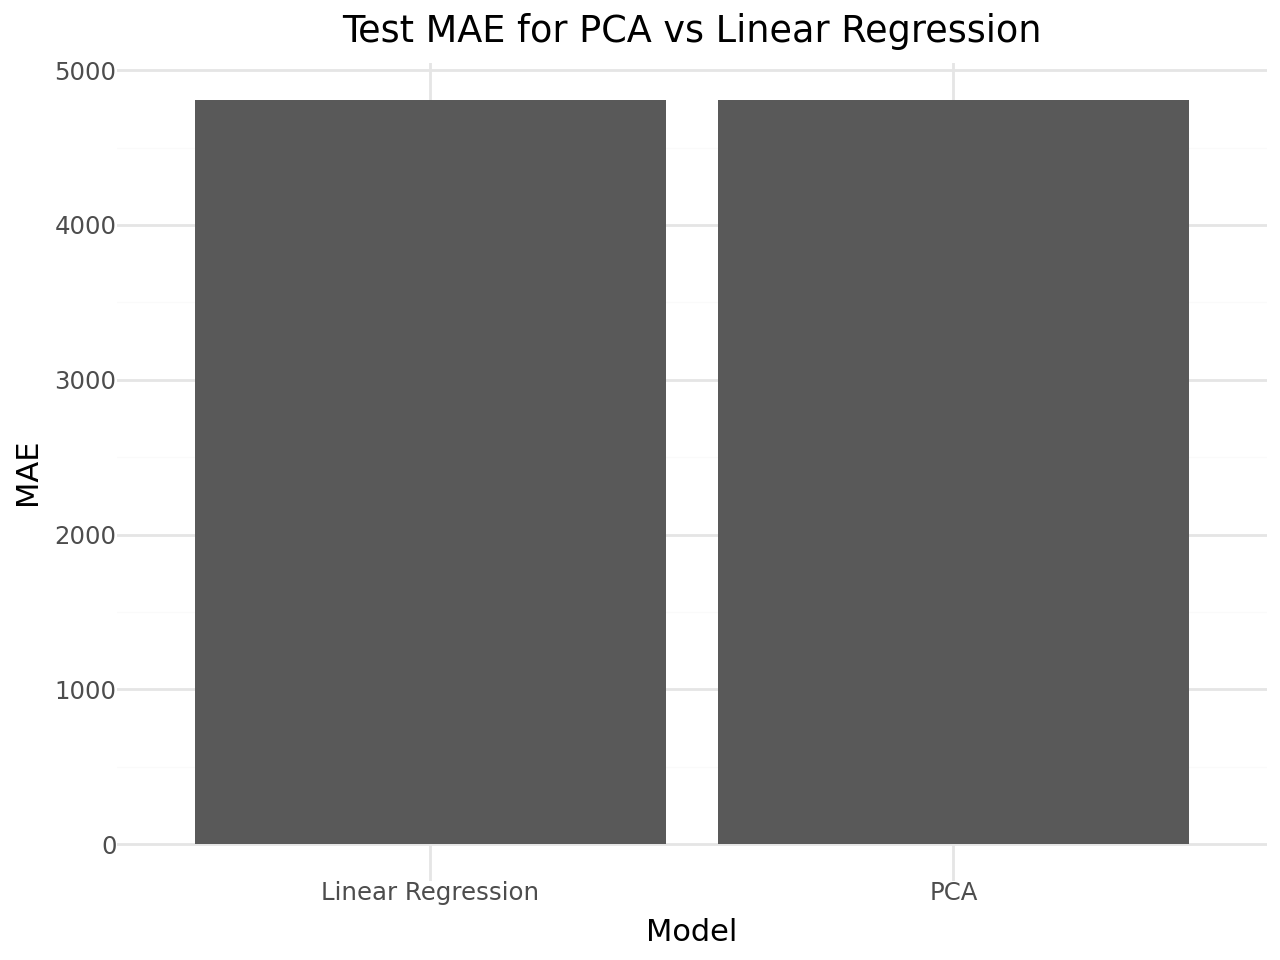

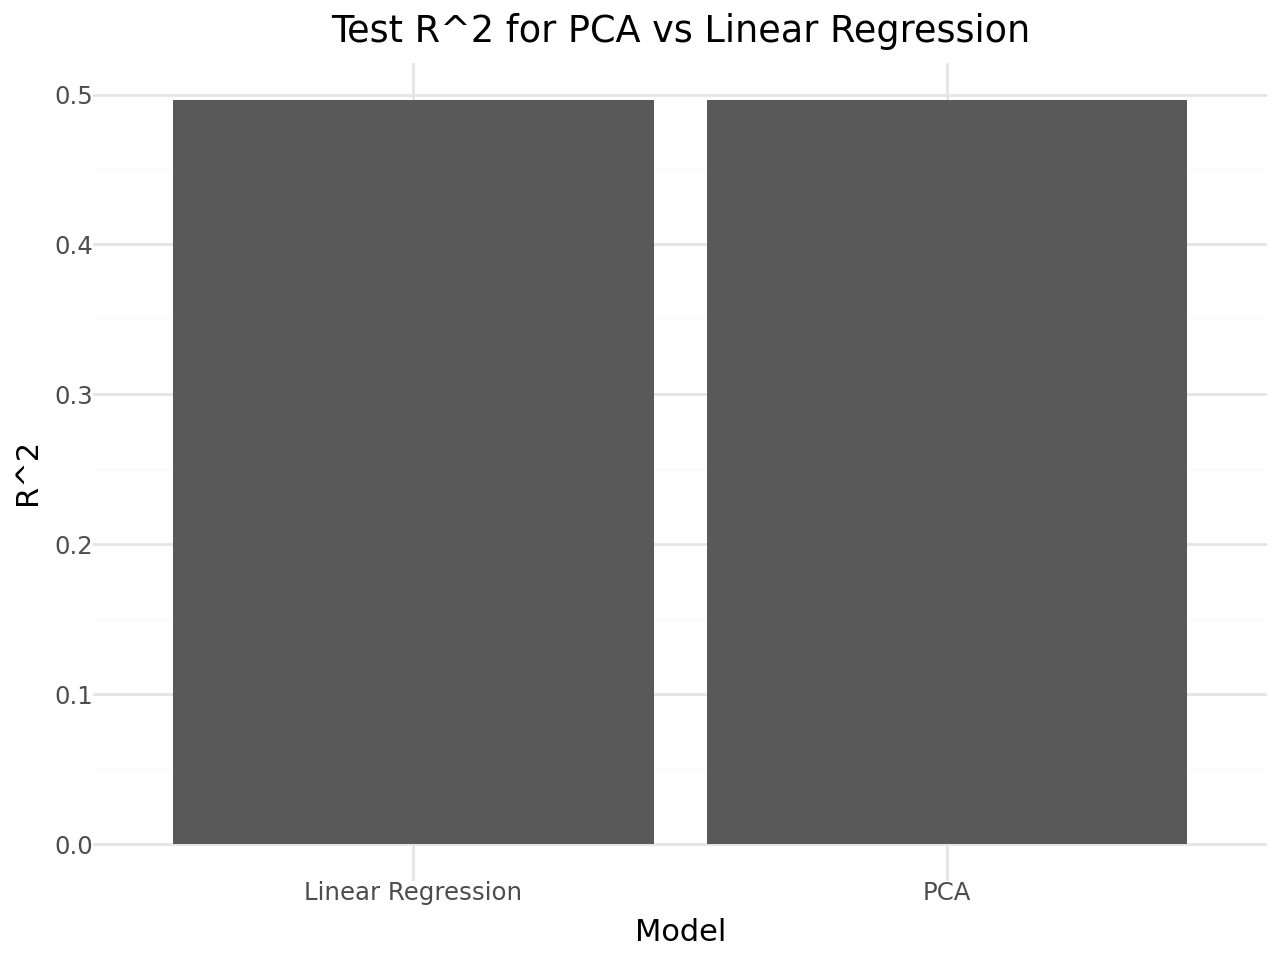

In [24]:
mse_pca_vs_lr = pd.DataFrame({
    "Model" : ["PCA", "Linear Regression"],
    "Values" : [mse_pca_test, mse_cont_test]
})

mae_pca_vs_lr = pd.DataFrame({
    "Model" : ["PCA", "Linear Regression"],
    "Values" : [mae_pca_test, mae_cont_test]
})

r2_pca_vs_lr = pd.DataFrame({
    "Model" : ["PCA", "Linear Regression"],
    "Values" : [r2_pca_test, r2_cont_test]
})

display(
    ggplot(mse_pca_vs_lr, aes(x = "Model", y = "Values")) +
    geom_col() +
    labs(title="Test MSE for PCA vs Linear Regression", x = "Model", y = "MSE") +
    theme_minimal()
)

display(
    ggplot(mae_pca_vs_lr, aes(x = "Model", y = "Values")) +
    geom_col() +
    labs(title="Test MAE for PCA vs Linear Regression", x = "Model", y = "MAE") +
    theme_minimal()
)

display(
    ggplot(r2_pca_vs_lr, aes(x="Model", y="Values")) +
    geom_col() +
    labs(title="Test R^2 for PCA vs Linear Regression", x = "Model", y = "R^2") +
    theme_minimal()
)

# Q3, Clustering

Q3
Question: When considering hp, year, price, and mileage, what clusters of vehicles emerge and
what defines these clusters?

Variables involved:  mileage (continuous), make (categorical), hp (continuous), year
(continuous/interval), price (continuous)

Cleaning:  Missing values will be dropped. All features/variables used will be Z scored.

Modeling/Computation: 2D ggplots will be created to visually identify if any clusters appear
and to see which clustering algorithm to use. After this step, the clustering algorithm will be fit
using any required metrics. Possible clustering algorithms are KMeans, GMM, DBSCAN, and
HAC. It is possible that a variety of clustering algorithms will be fit and then each evaluated on
their performance. After clusters are fit, a summary table will be created to define the
membership of each cluster

Graphs: The above ggplots will be reused to show how the algorithm clustered the data. If
using HAC, a dendrogram will be present. In the case of multiple clustering algorithms being fit
to determine the best performance, a bar chart will be created showing each models
performance using a relevant metric (silhouette score, bic, etc.)

Brief discussion of why analysis is effective at answering question: This analysis is
effective in answering the question as it analyzes what clusters appear and how those clusters
are defined.

### Only using continuous variables as clustering can only handle those

In [16]:
clust_cols = ["mileage", "hp", "year", "price"]

c_cars = cars[clust_cols]

### Visualizing Data

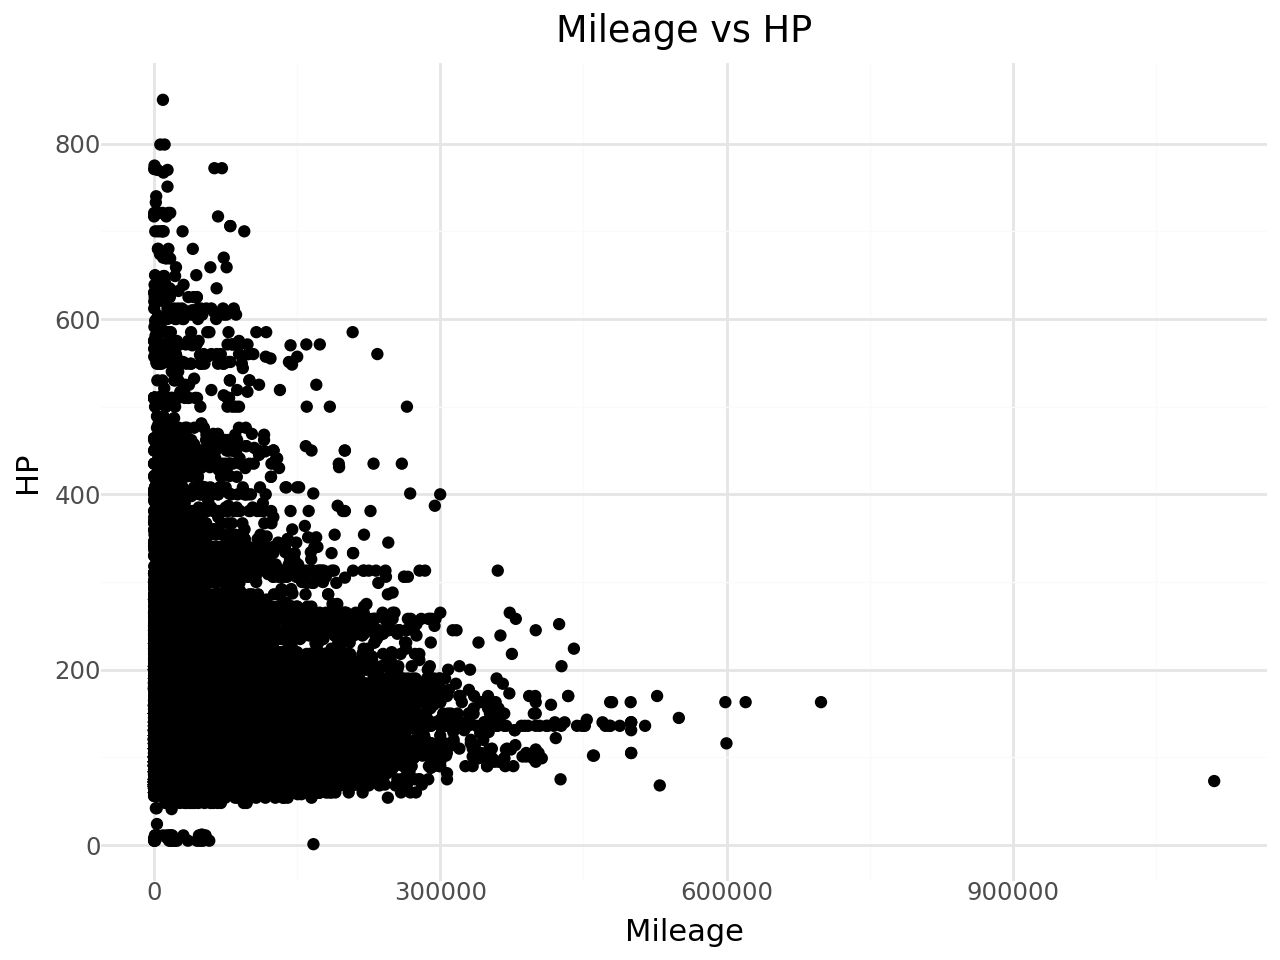

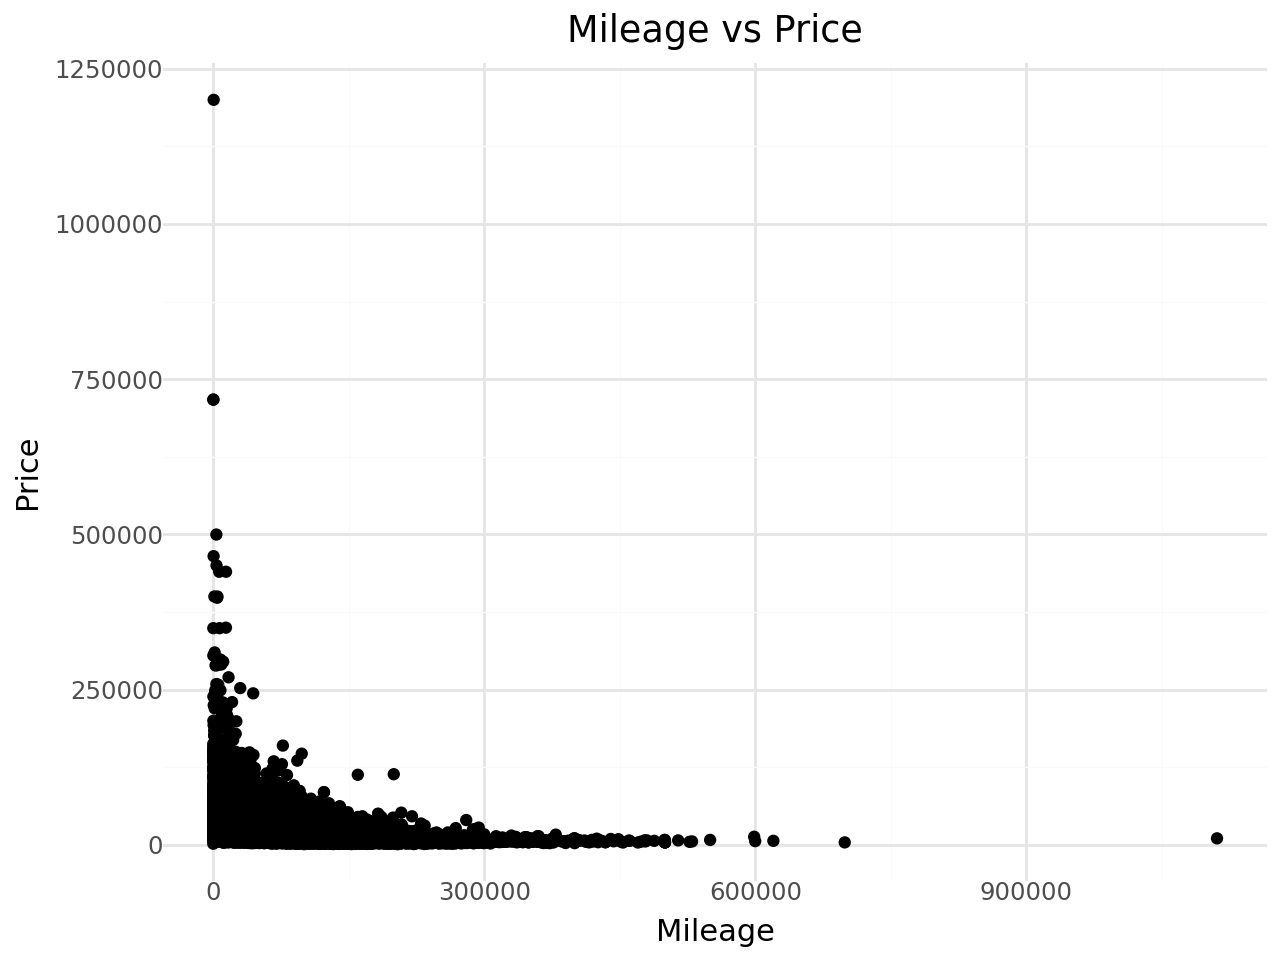

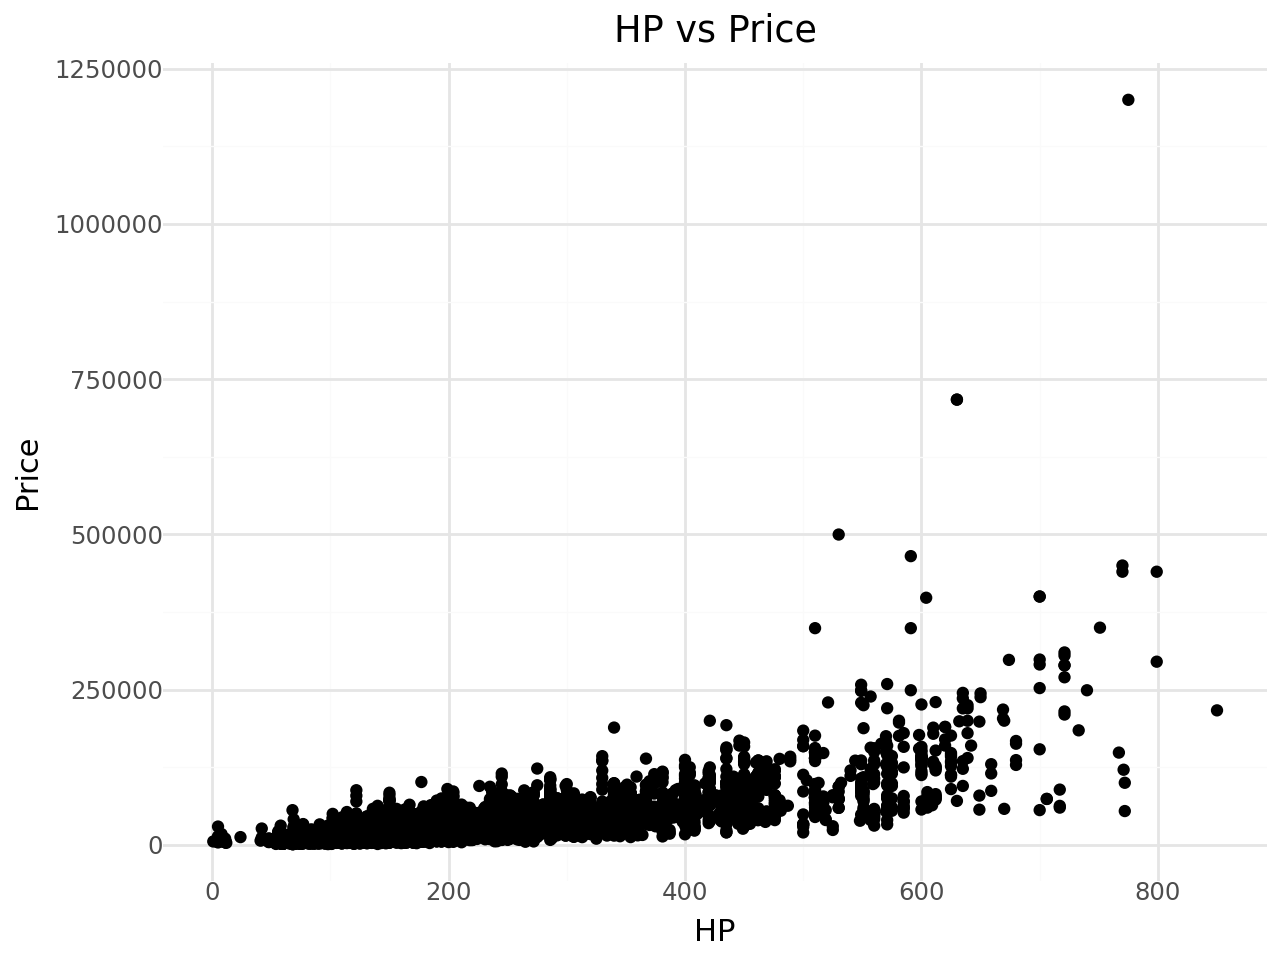

In [17]:
display(ggplot(c_cars, aes(x = "mileage", y = "hp")) +
 geom_point() + labs(title = "Mileage vs HP", x = "Mileage", y = "HP") +
 theme_minimal())

display(ggplot(c_cars, aes(x = "mileage", y = "price")) +
 geom_point() + labs(title = "Mileage vs Price", x = "Mileage", y = "Price") +
 theme_minimal())

display(ggplot(c_cars, aes(x = "hp", y = "price")) +
 geom_point() + labs(title = "HP vs Price", x = "HP", y = "Price") +
 theme_minimal())

### Taking Sample of Data

Ran into computational/hardware limitations with HAC, having to take random sample of data to see how clustering does

In [18]:
# REFERENCE FOR .sample: https://www.geeksforgeeks.org/python-pandas-dataframe-sample/
c_cars_small = c_cars.sample(n = 5000, random_state = 42) # for hardware limitations

scaler = StandardScaler()

X = scaler.fit_transform(c_cars_small)

hac = AgglomerativeClustering(linkage = "ward",
                              metric = "euclidean",
                              distance_threshold=0,
                              n_clusters = None)

labels = hac.fit_predict(X)

### Plotting Dendrogram to Pick \# Clusters

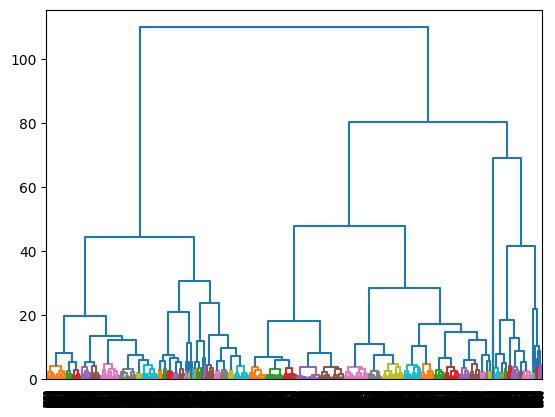

In [19]:
def plot_dendrogram(hac, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(hac.children_.shape[0])
    n_samples = len(hac.labels_)
    for i, merge in enumerate(hac.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [hac.children_, hac.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sch.dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(hac, color_threshold = 5)

### Checkign Silhouette Scores for Different \# Clusters

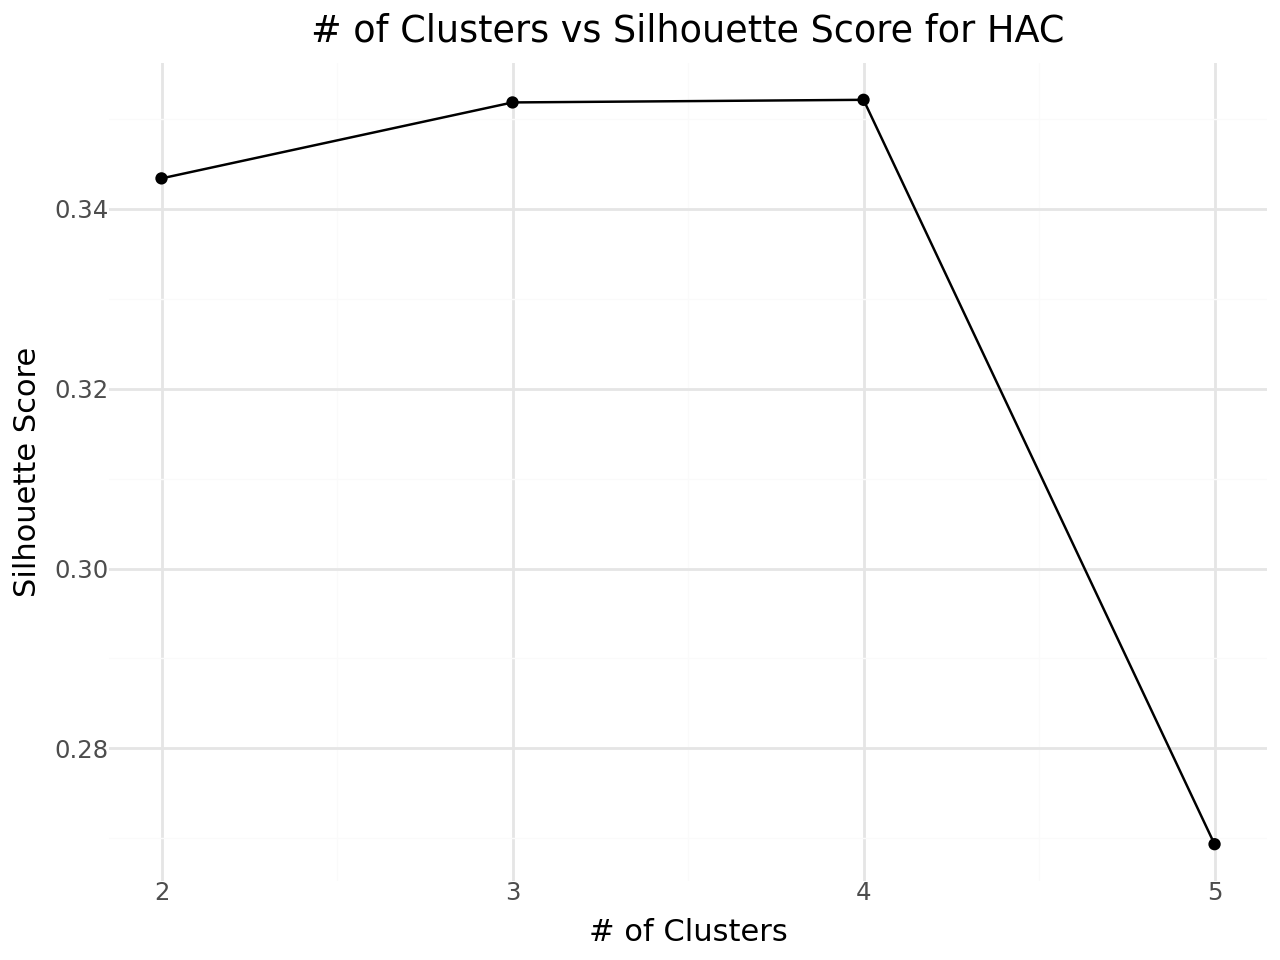

Silhouette Score for 3 clusters:  0.35184884131313193
Silhouette Score for 4 clusters:  0.35213982678840106


In [20]:
n_clusts = list(range(2,6))

sil_scores = []

for i in n_clusts:
  hac = AgglomerativeClustering(linkage = "ward", metric = "euclidean", n_clusters = i)

  labels = hac.fit_predict(X)

  sil_scores.append(silhouette_score(X, labels))

sil_scores_df = pd.DataFrame({"n_clusters": n_clusts,
                              "silhouette_score": sil_scores})

# plotting silhouette scores with num clusters
display(ggplot(sil_scores_df, aes(x = "n_clusters", y = "silhouette_score")) + geom_line() + geom_point() + theme_minimal() + labs(title = "# of Clusters vs Silhouette Score for HAC", x = "# of Clusters", y = "Silhouette Score"))

print("Silhouette Score for 3 clusters: ", sil_scores[1])
print("Silhouette Score for 4 clusters: ", sil_scores[2])

### Building HAC with Chosen \# Clusters

In [21]:
hac = AgglomerativeClustering(linkage = "ward", metric = "euclidean", n_clusters = 4)

labels = hac.fit_predict(X)

print(f"Silhouette Score: {silhouette_score(X, labels)}")

Silhouette Score: 0.35213982678840106


### Summary Table

In [22]:
c_cars_small["cluster"] = labels

hac_summary = c_cars_small.groupby("cluster").mean().round(2)

hac_summary["count"] = c_cars_small["cluster"].value_counts()
hac_summary["propoortion"] = c_cars_small["cluster"].value_counts(normalize = True).round(2)
hac_summary

,mileage,hp,year,price,count,propoortion
cluster,,,,,,
0,37767.11,116.58,2017.91,16368.99,2460,0.49
1,124410.04,118.73,2012.96,8400.44,2045,0.41
2,30011.56,294.43,2018.92,50721.11,492,0.10
3,1590.67,669.67,2017.67,771659.33,3,0.00


### Showing How Data was Clustered

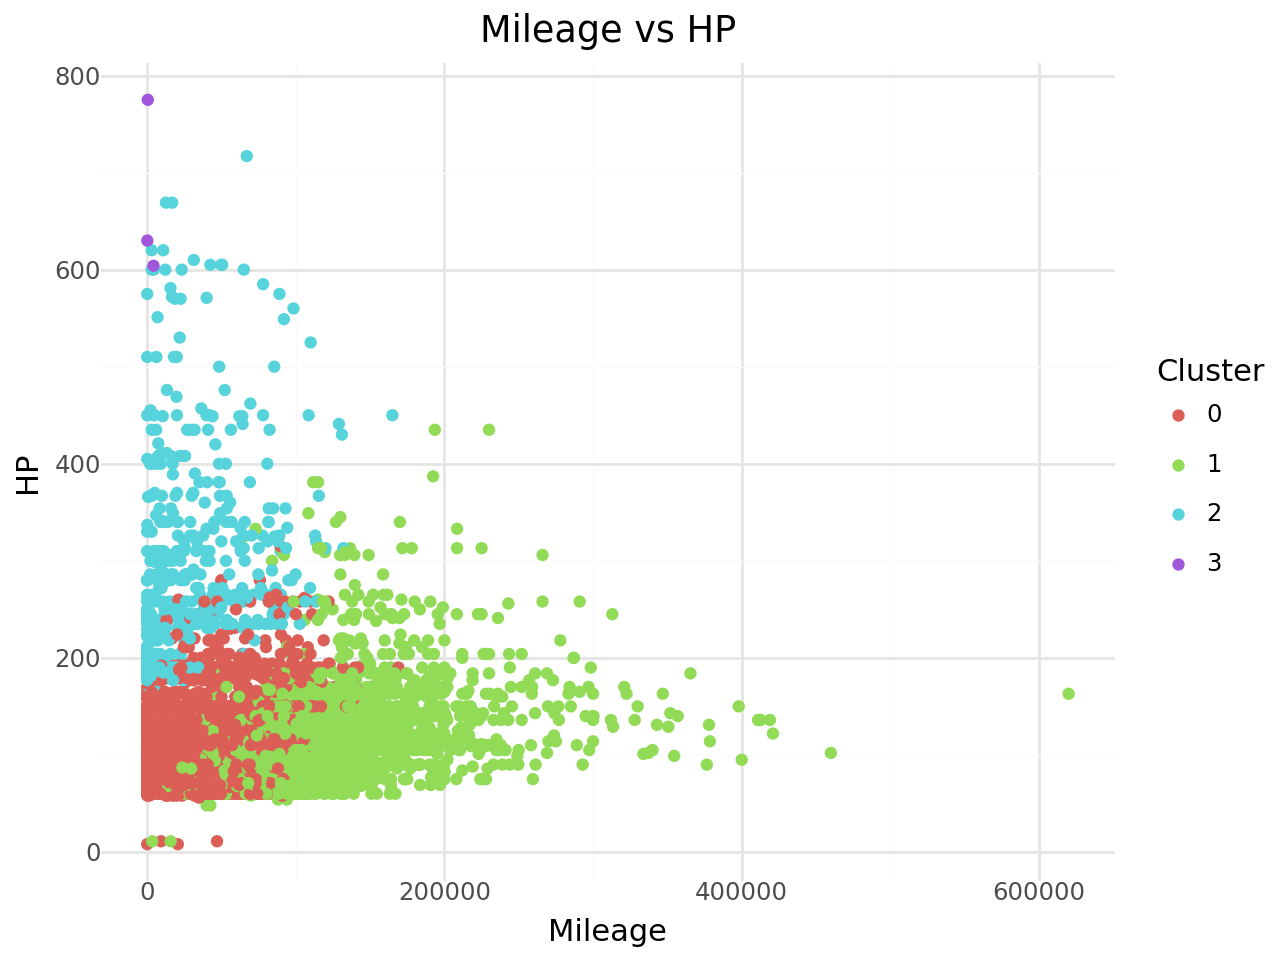

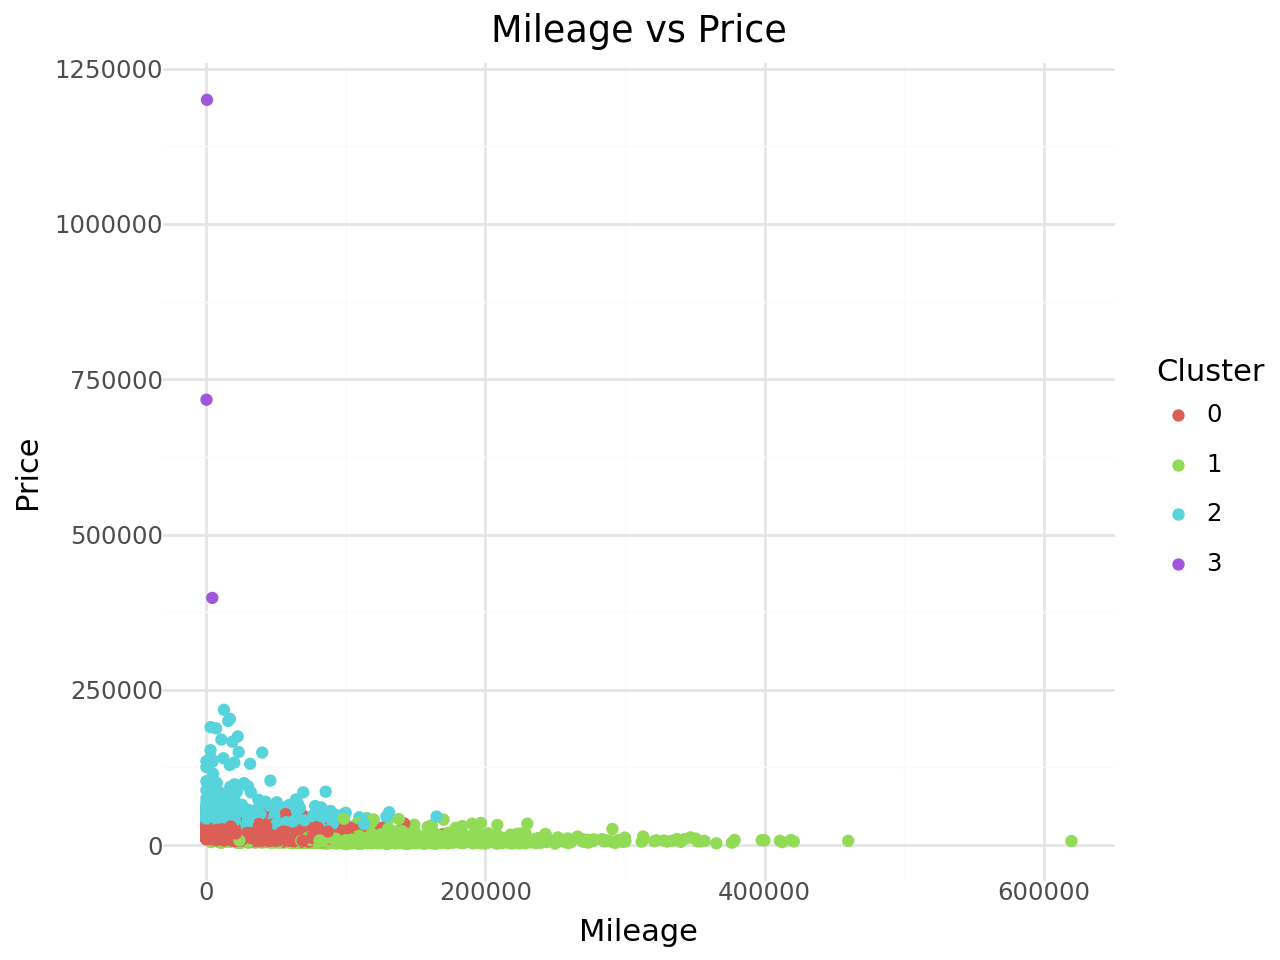

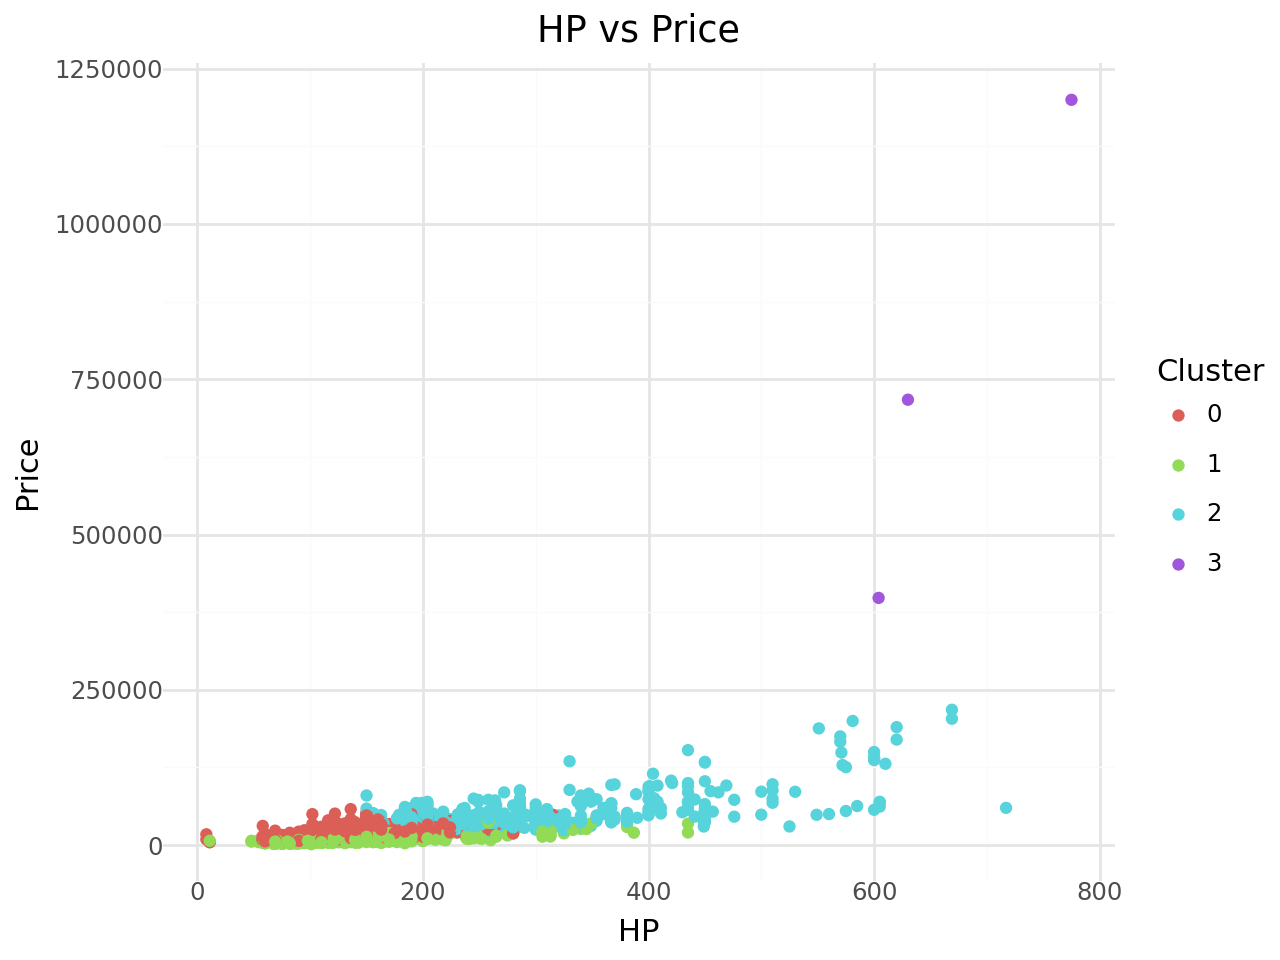

In [23]:
display(ggplot(c_cars_small, aes(x = "mileage", y = "hp", color = "factor(labels)")) +
 geom_point() + labs(title = "Mileage vs HP", x = "Mileage", y = "HP", color = "Cluster") +
 theme_minimal())

display(ggplot(c_cars_small, aes(x = "mileage", y = "price", color = "factor(labels)")) +
 geom_point() + labs(title = "Mileage vs Price", x = "Mileage", y = "Price", color = "Cluster") +
 theme_minimal())

display(ggplot(c_cars_small, aes(x = "hp", y = "price", color = "factor(labels)")) +
 geom_point() + labs(title = "HP vs Price", x = "HP", y = "Price", color = "Cluster") +
 theme_minimal())
